# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [53]:
METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
    # # "metrics_auction_valuation_rates_2023-03-24-16-06.tar.xz",
    # # # "metrics_cloud_only_valuation_rates_2023-03-24-15-44.tar.xz",
    # # "metrics_edge_first_valuation_rates_2023-03-24-16-07.tar.xz",
    # # "metrics_edge_ward_valuation_rates_2023-03-24-15-39.tar.xz",
    # # "metrics_auction_valuation_resources_2023-03-24-15-39.tar.xz",
    # # "metrics_cloud_only_valuation_resources_2023-03-24-15-39.tar.xz",
    # # "metrics_edge_first_valuation_resources_2023-03-24-15-38.tar.xz",
    # # "metrics_edge_ward_valuation_resources_2023-03-24-15-39.tar.xz",
    # # "metrics_auction_valuation_rates_same_rates_2023-03-24-16-41.tar.xz",
    # # # "metrics_cloud_only_valuation_rates_same_rates_2023-03-24-16-40.tar.xz",
    # # "metrics_edge_first_valuation_rates_same_rates_2023-03-24-17-04.tar.xz",
    # # "metrics_edge_ward_valuation_rates_same_rates_2023-03-24-16-39.tar.xz",
    # # "metrics_auction_valuation_rates_lowest_cloud_2023-03-27-15-57.tar.xz",
    # # "metrics_cloud_only_valuation_rates_lowest_cloud_2023-03-27-16-00.tar.xz",
    # # "metrics_edge_first_valuation_rates_lowest_cloud_2023-03-27-15-57.tar.xz",
    # # "metrics_edge_ward_valuation_rates_lowest_cloud_2023-03-27-15-56.tar.xz",
    # "metrics_auction_valuation_rates_lowest_cloud_less_ll_2023-03-28-08-54.tar.xz",
    # # "metrics_cloud_only_valuation_rates_lowest_cloud_less_ll_2023-03-28-09-13.tar.xz",
    # "metrics_edge_first_valuation_rates_lowest_cloud_less_ll_2023-03-28-08-52.tar.xz",
    # "metrics_edge_ward_valuation_rates_lowest_cloud_less_ll_2023-03-28-08-52.tar.xz"
    "metrics_auction_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-22.tar.xz",
    "metrics_cloud_only_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-33.tar.xz",
    "metrics_edge_first_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-26.tar.xz",
    "metrics_edge_ward_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-25.tar.xz",
    "metrics_auction_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-05.tar.xz",
    # "metrics_cloud_only_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-03.tar.xz",
    "metrics_edge_first_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-00.tar.xz",
    "metrics_edge_ward_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-01.tar.xz"
    ) # looks at "./*"

METRICS_GROUP <- c(
    # # "auction",
    # # # "cloud_only",
    # # "edge_first",
    # # "edge_ward",
    # # "auction_resources",
    # # "cloud_only_resources",
    # # "edge_first_resources",
    # # "edge_ward_resources",
    # # "auction_same",
    # # # "cloud_only_same",
    # # "edge_first_same",
    # # "edge_ward_same",
    # # "auction",
    # # "cloud_only",
    # # "edge_first",
    # # "edge_ward",
    # "auction",
    # # "cloud_only",
    # "edge_first",
    # "edge_ward"
    # "auction"
    # # "cloud_only",
    # "edge_first",
    # "edge_ward",
    "auction",
    "cloud_only",
    "edge_first",
    "edge_ward",
    "auction",
    # "cloud_only",
    "edge_first",
    "edge_ward"
)


In [54]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

# To call python from R
library(archive)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(data.table)
library(scales)


theme_set(theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    panel.background = element_rect(fill = "white"),
    panel.grid = element_blank(),
))


Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [55]:
# use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))


The graph of the network

In [56]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)


In [57]:
node_levels <- stack(py$LEVELS) %>%
    mutate(name = ind, level = values) %>%
    select(-c(ind)) %>%
    mutate(level = case_when(
        level == 0 ~ "Cloud",
        level == max(level) - 1 ~ "Edge+1",
        level == max(level) ~ "Edge",
        TRUE ~ paste("Cloud", as.character(level), sep = "+")
    ))

# node_levels


Load the names of the node and their correspondance in their IP on the virtual network

In [58]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(read.csv2(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), header = TRUE, sep = "\t"),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)]
    ))
    return(all_data)
}


In [59]:
names_raw <- load_csv("names.csv")
missing <- data.frame(instance = names_raw$name, n = 0)

# names_raw


In [60]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(20, 20)

adjust_timestamps <- function(x) {
  return(
    x %>%
      group_by(folder) %>%
      mutate(timestamp = timestamp - min(timestamp)) %>%
      ungroup()
  )
}

prepare <- function(x) {
  return(
    x %>%
      inner_join(names_raw, c("instance", "folder", "metric_group")) %>%
      mutate(instance = name.y) %>%
      mutate(timestamp = as.POSIXct(as.numeric(as.character(timestamp)), origin = "1970-01-01")) %>%
      mutate(value = as.numeric(value)) %>%
      adjust_timestamps() %>%
      # merge(missing, all = TRUE) %>%
      # arrange(instance) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)-([0-9]+)-([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(latency = info %>% .[, 4]) %>%
      mutate(cpu = info %>% .[, 5]) %>%
      mutate(mem = info %>% .[, 6]) %>%
      mutate(load_type = info %>% .[, 7]) %>%
      mutate(latency_type = info %>% .[, 8]) %>%
      mutate(nb_fn_low_interval_low_latency = info %>% .[, 9]) %>%
      mutate(nb_fn_high_interval_low_latency = info %>% .[, 10]) %>%
      mutate(latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency"
      )) %>%
      mutate(load_type = case_when(
        load_type == "low" ~ "High load",
        load_type == "high" ~ "Low load"
      ))
  )
}


## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [61]:
mem <- load_csv("fog_node_memory_available.csv") %>%
    prepare() %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value, folder)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu <- load_csv("fog_node_cpu_used.csv") %>%
    prepare() %>%
    select(c(instance, value, folder)) %>%
    distinct(instance, value, folder, .keep_all = TRUE) %>%
    group_by(instance, folder) %>%
    mutate(value = as.numeric(as.character(value)))


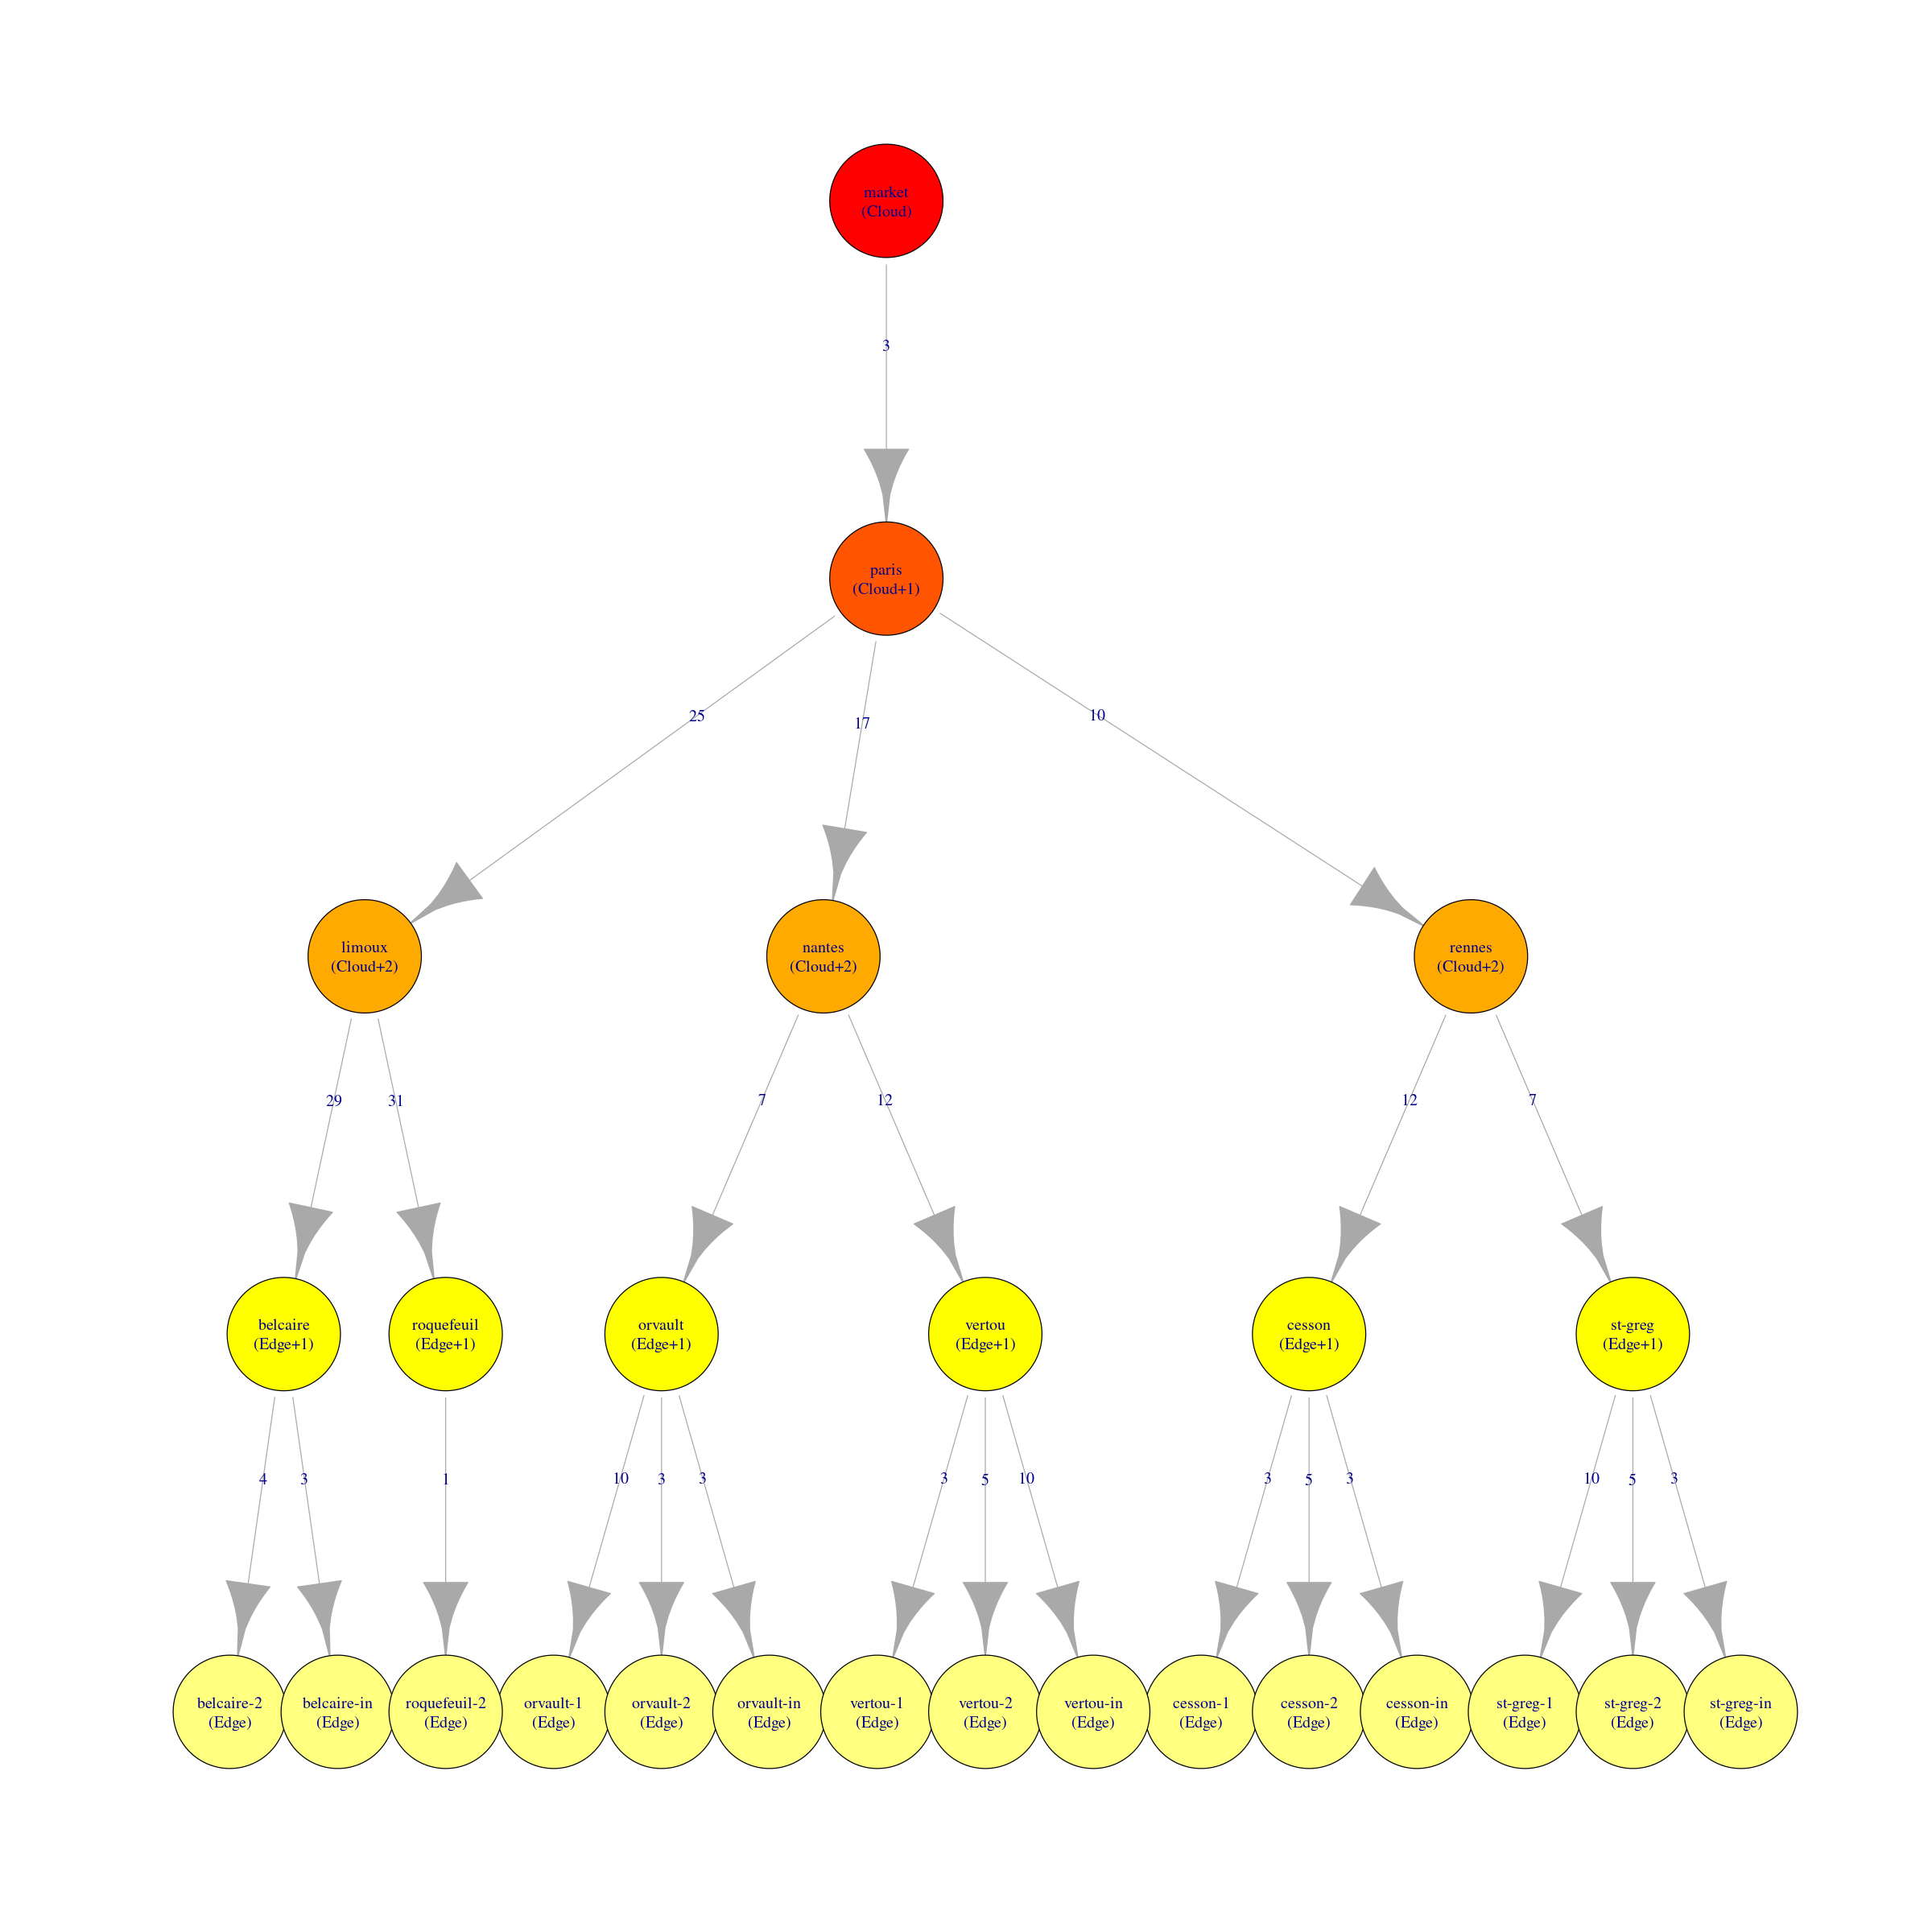

In [62]:
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
colors <- heat.colors(length(unique(node_levels$level)))
node_level_map <- setNames(node_levels$level, node_levels$name)
color_map <- setNames(colors, unique(node_levels$level))

node_names <- merge(data.frame(name = V(net_connected)$name, stringsAsFactors = FALSE), node_levels, by.x = "name", by.y = "name")
node_names$name <- paste(node_names$name, paste("(", node_names$level, ")", sep = ""), sep = "\n")

V(net_connected)$color <- color_map[node_level_map[V(net_connected)$name]]
V(net_connected)$name <- node_names$name

plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)


## Distribution of the functions in the network

Plot the free cpu

In [63]:
# cpu_used <- load_csv("fog_node_cpu_used.csv") %>% prepare()
# cpu_avail <- load_csv("fog_node_cpu_available.csv") %>% prepare()


# cpu_free <- cpu_used %>%
#   inner_join(cpu_avail, by = c("instance", "timestamp", "folder", "metric_group")) %>%
#   mutate(free = (value.y - value.x) / 1e09) %>%
#   group_by(instance, folder, metric_group) %>%
#   mutate(free_percent = formattable::percent(free / max(free))) %>%
#   select(instance, timestamp, free, free_percent, folder) %>%
#   drop_na()

# cpu_free %>%
#   ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
#   # geom_area(position = 'stack',  color = "white") +
#   geom_line() +
#   labs(
#     x = "Time",
#     y = "Free CPU",
#     title = "Free cpu in fog_nodes over time",
#     subtitle = "Fog Node representation"
#   ) +
#   facet_grid(cols = vars(folder), scale = "free") +
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE)


Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



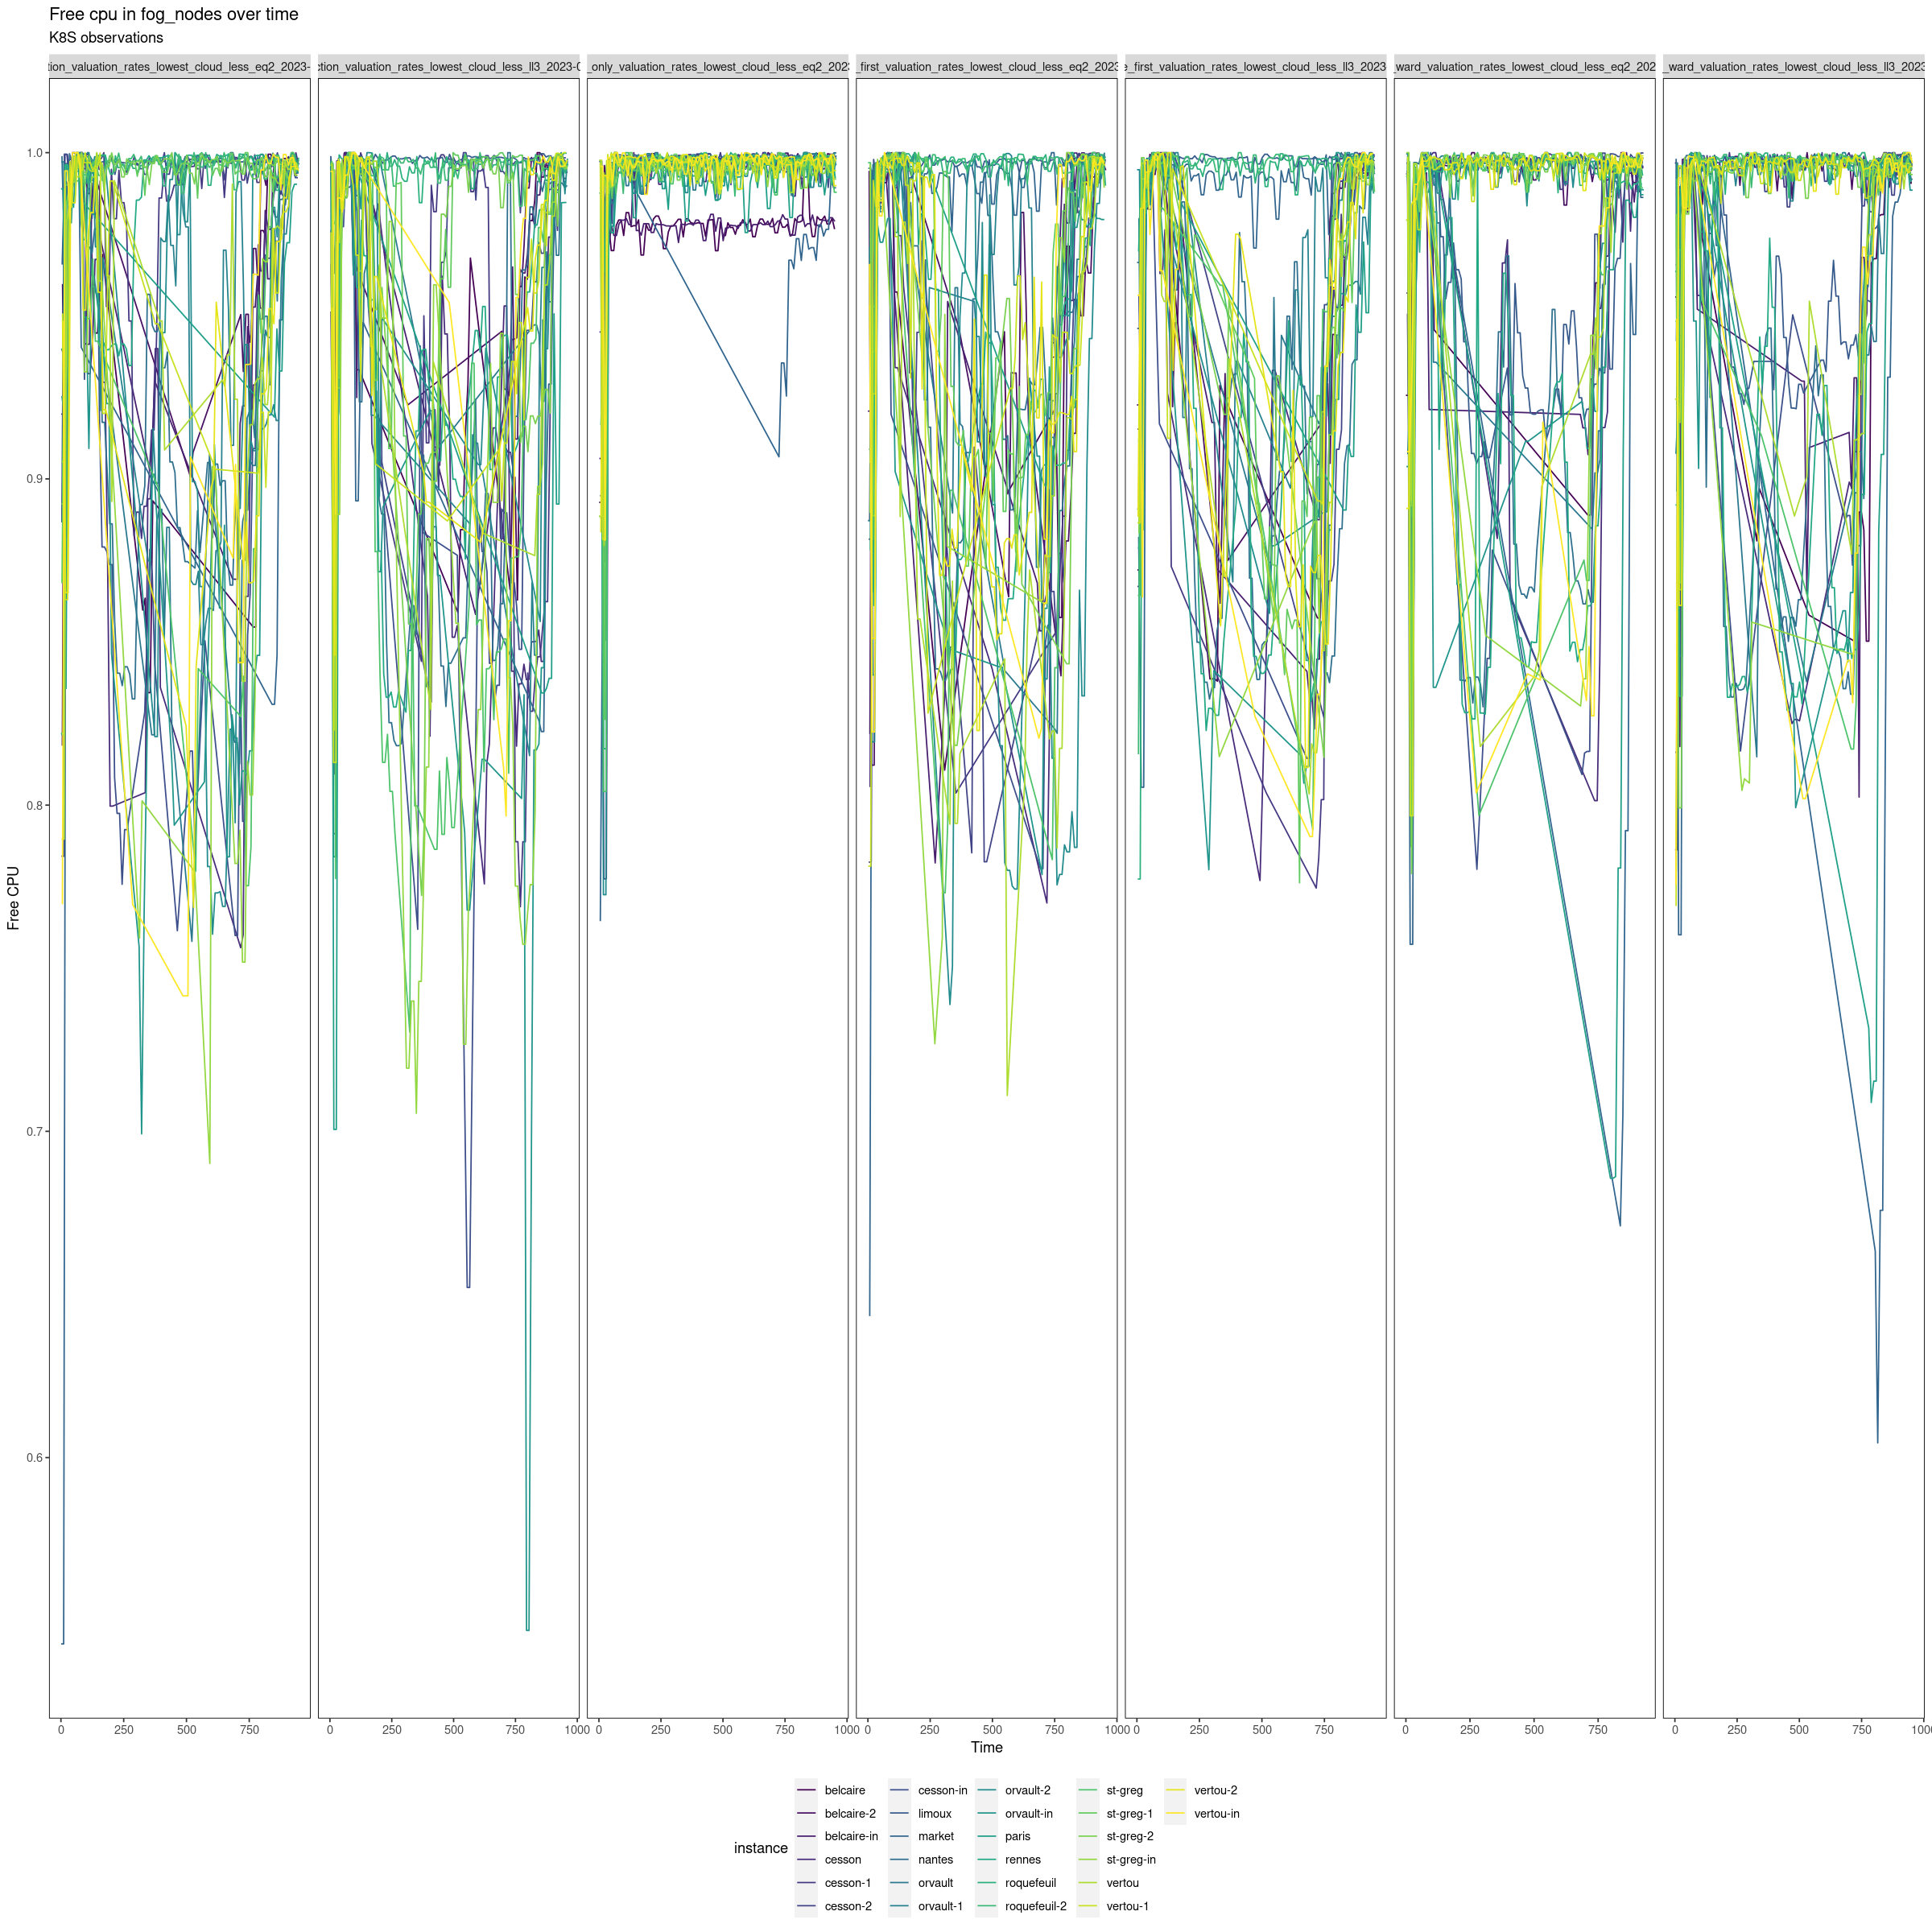

In [64]:
cpu_used <- load_csv("fog_node_cpu_usage.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_allocatable.csv") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free))) %>%
  select(instance, timestamp, free, free_percent, folder) %>%
  drop_na()

cpu_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  # geom_area(position = 'stack',  color = "white") +
  geom_line() +
  labs(
    x = "Time",
    y = "Free CPU",
    title = "Free cpu in fog_nodes over time",
    subtitle = "K8S observations"
  ) +
  facet_grid(cols = vars(folder), scale = "free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)


Plot the free memory

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



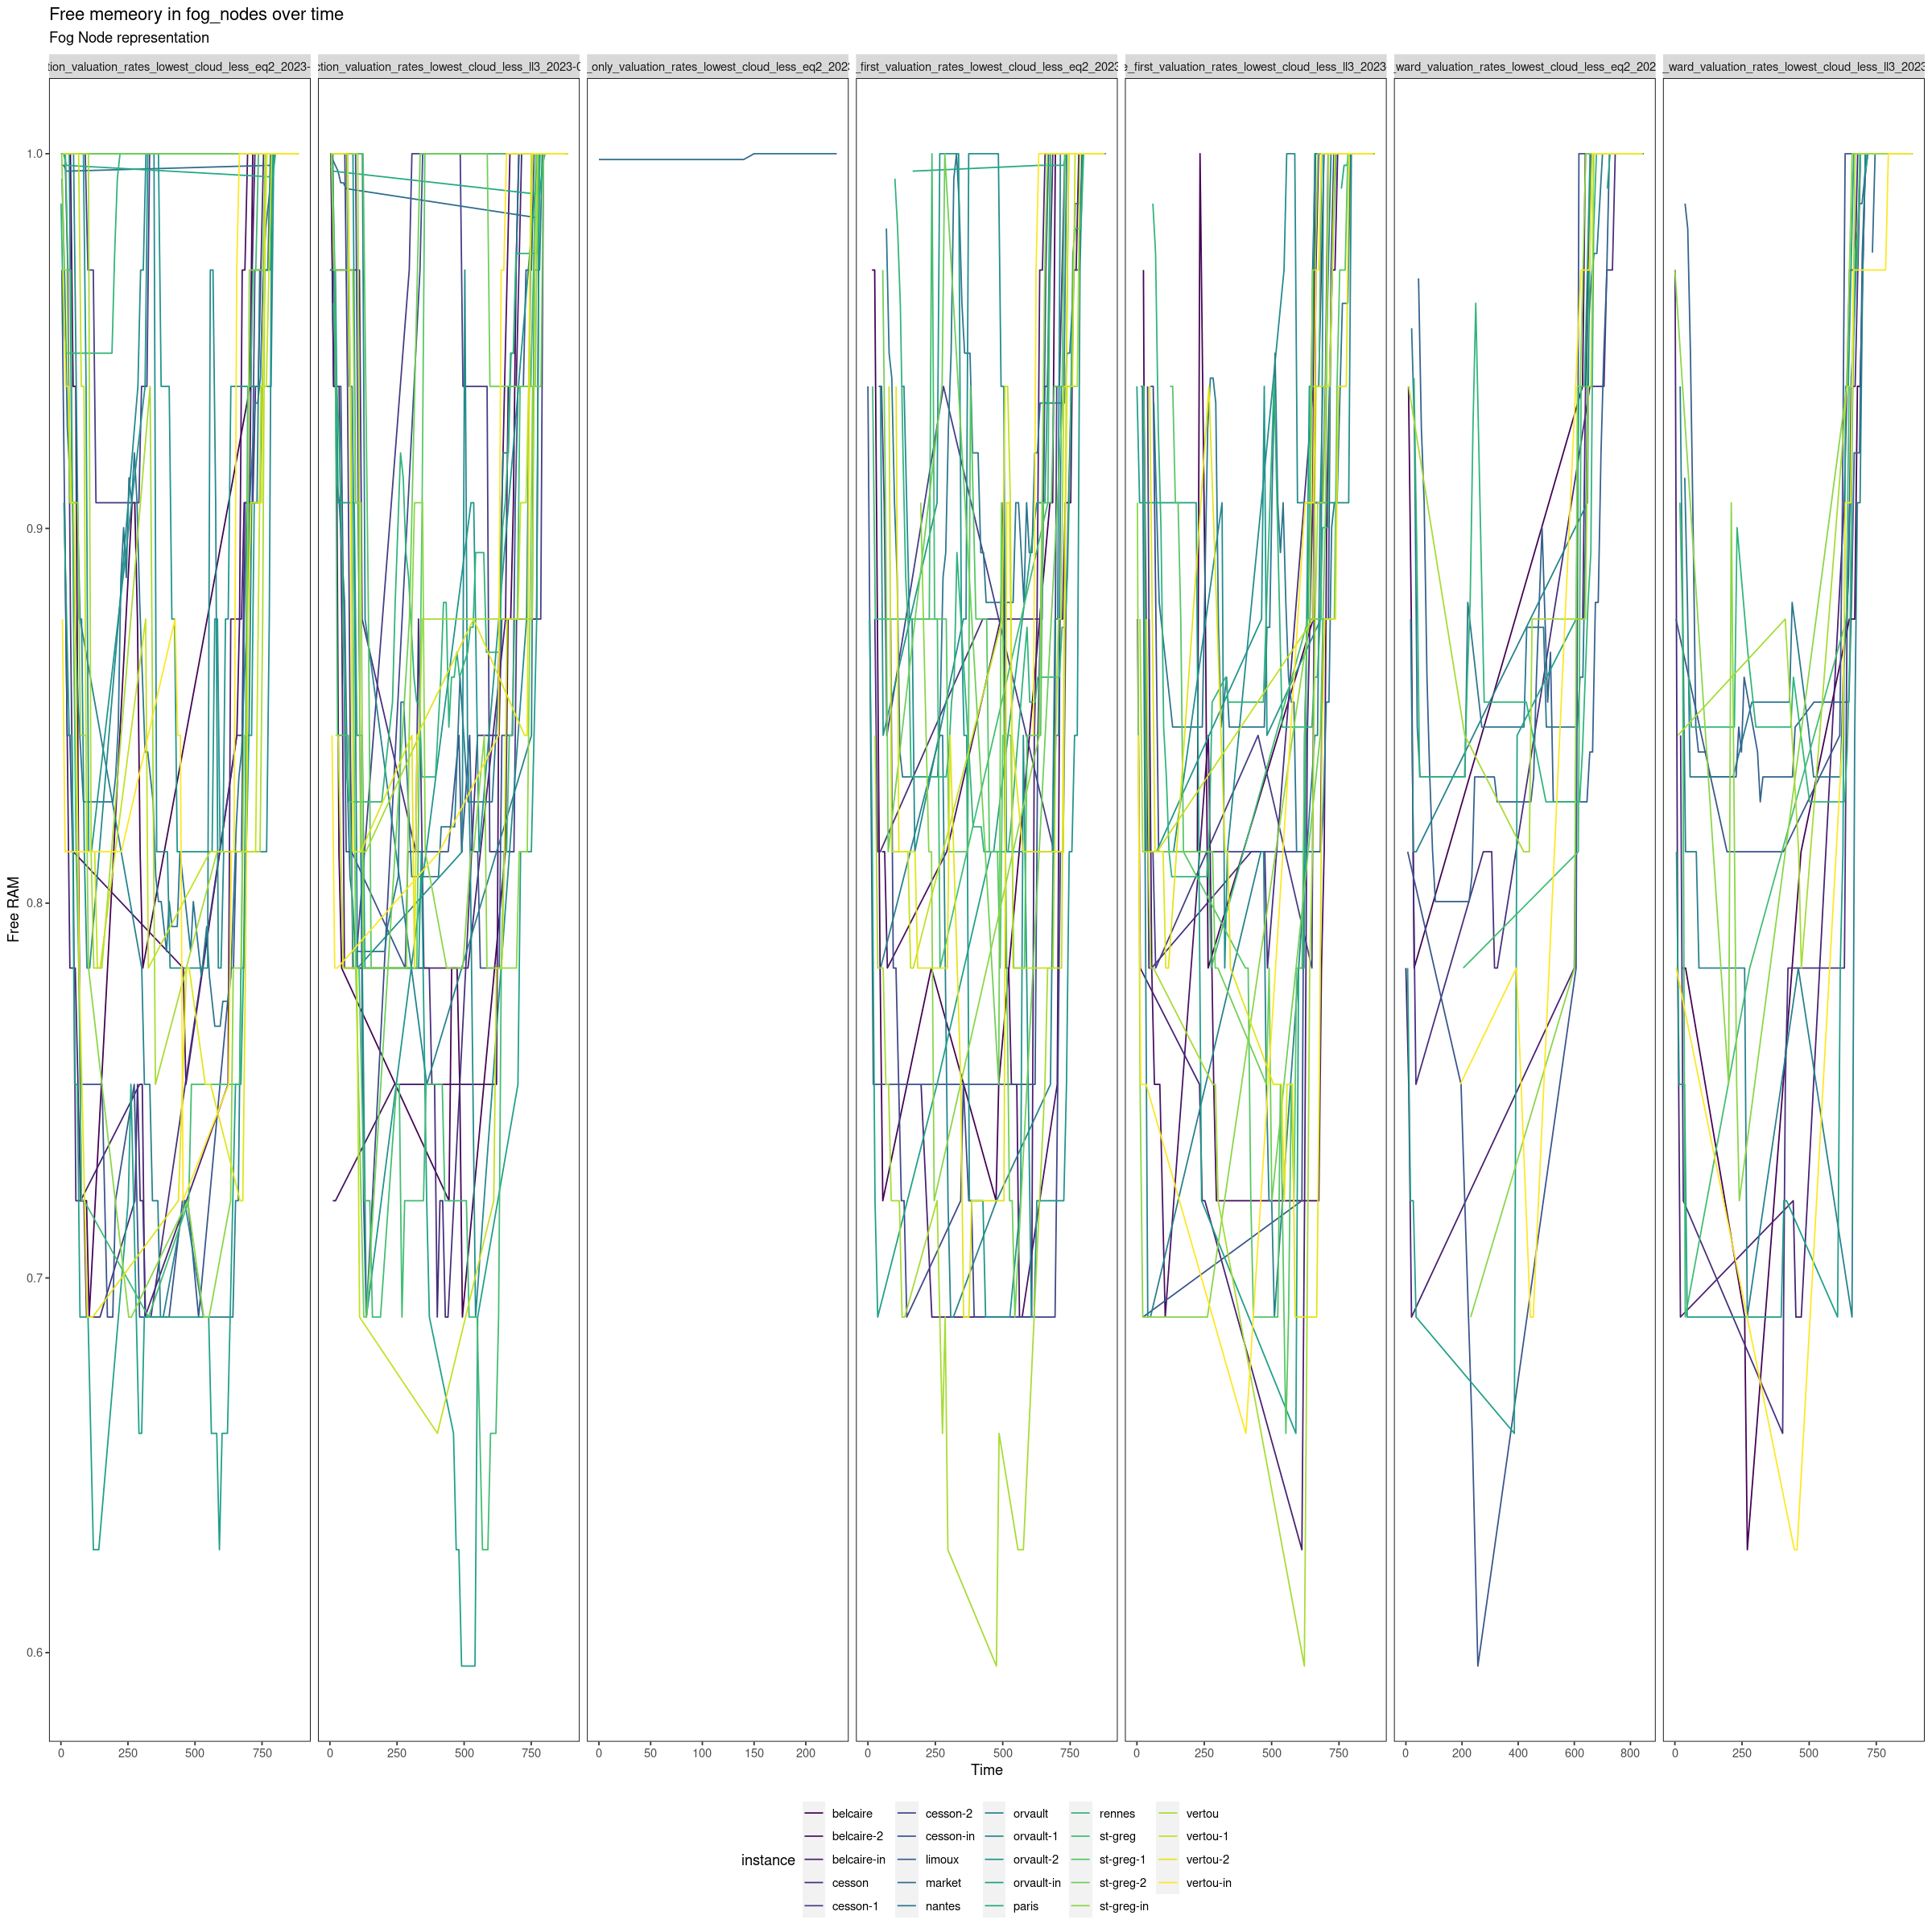

In [65]:
mem_used <- load_csv("fog_node_memory_used.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_available.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder) %>%
  drop_na()

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  # geom_area(position = 'stack', color = "white") +
  geom_line() +
  facet_grid(cols = vars(folder), scale = "free") +
  labs(
    x = "Time",
    y = "Free RAM",
    title = "Free memeory in fog_nodes over time",
    subtitle = "Fog Node representation"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)


Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



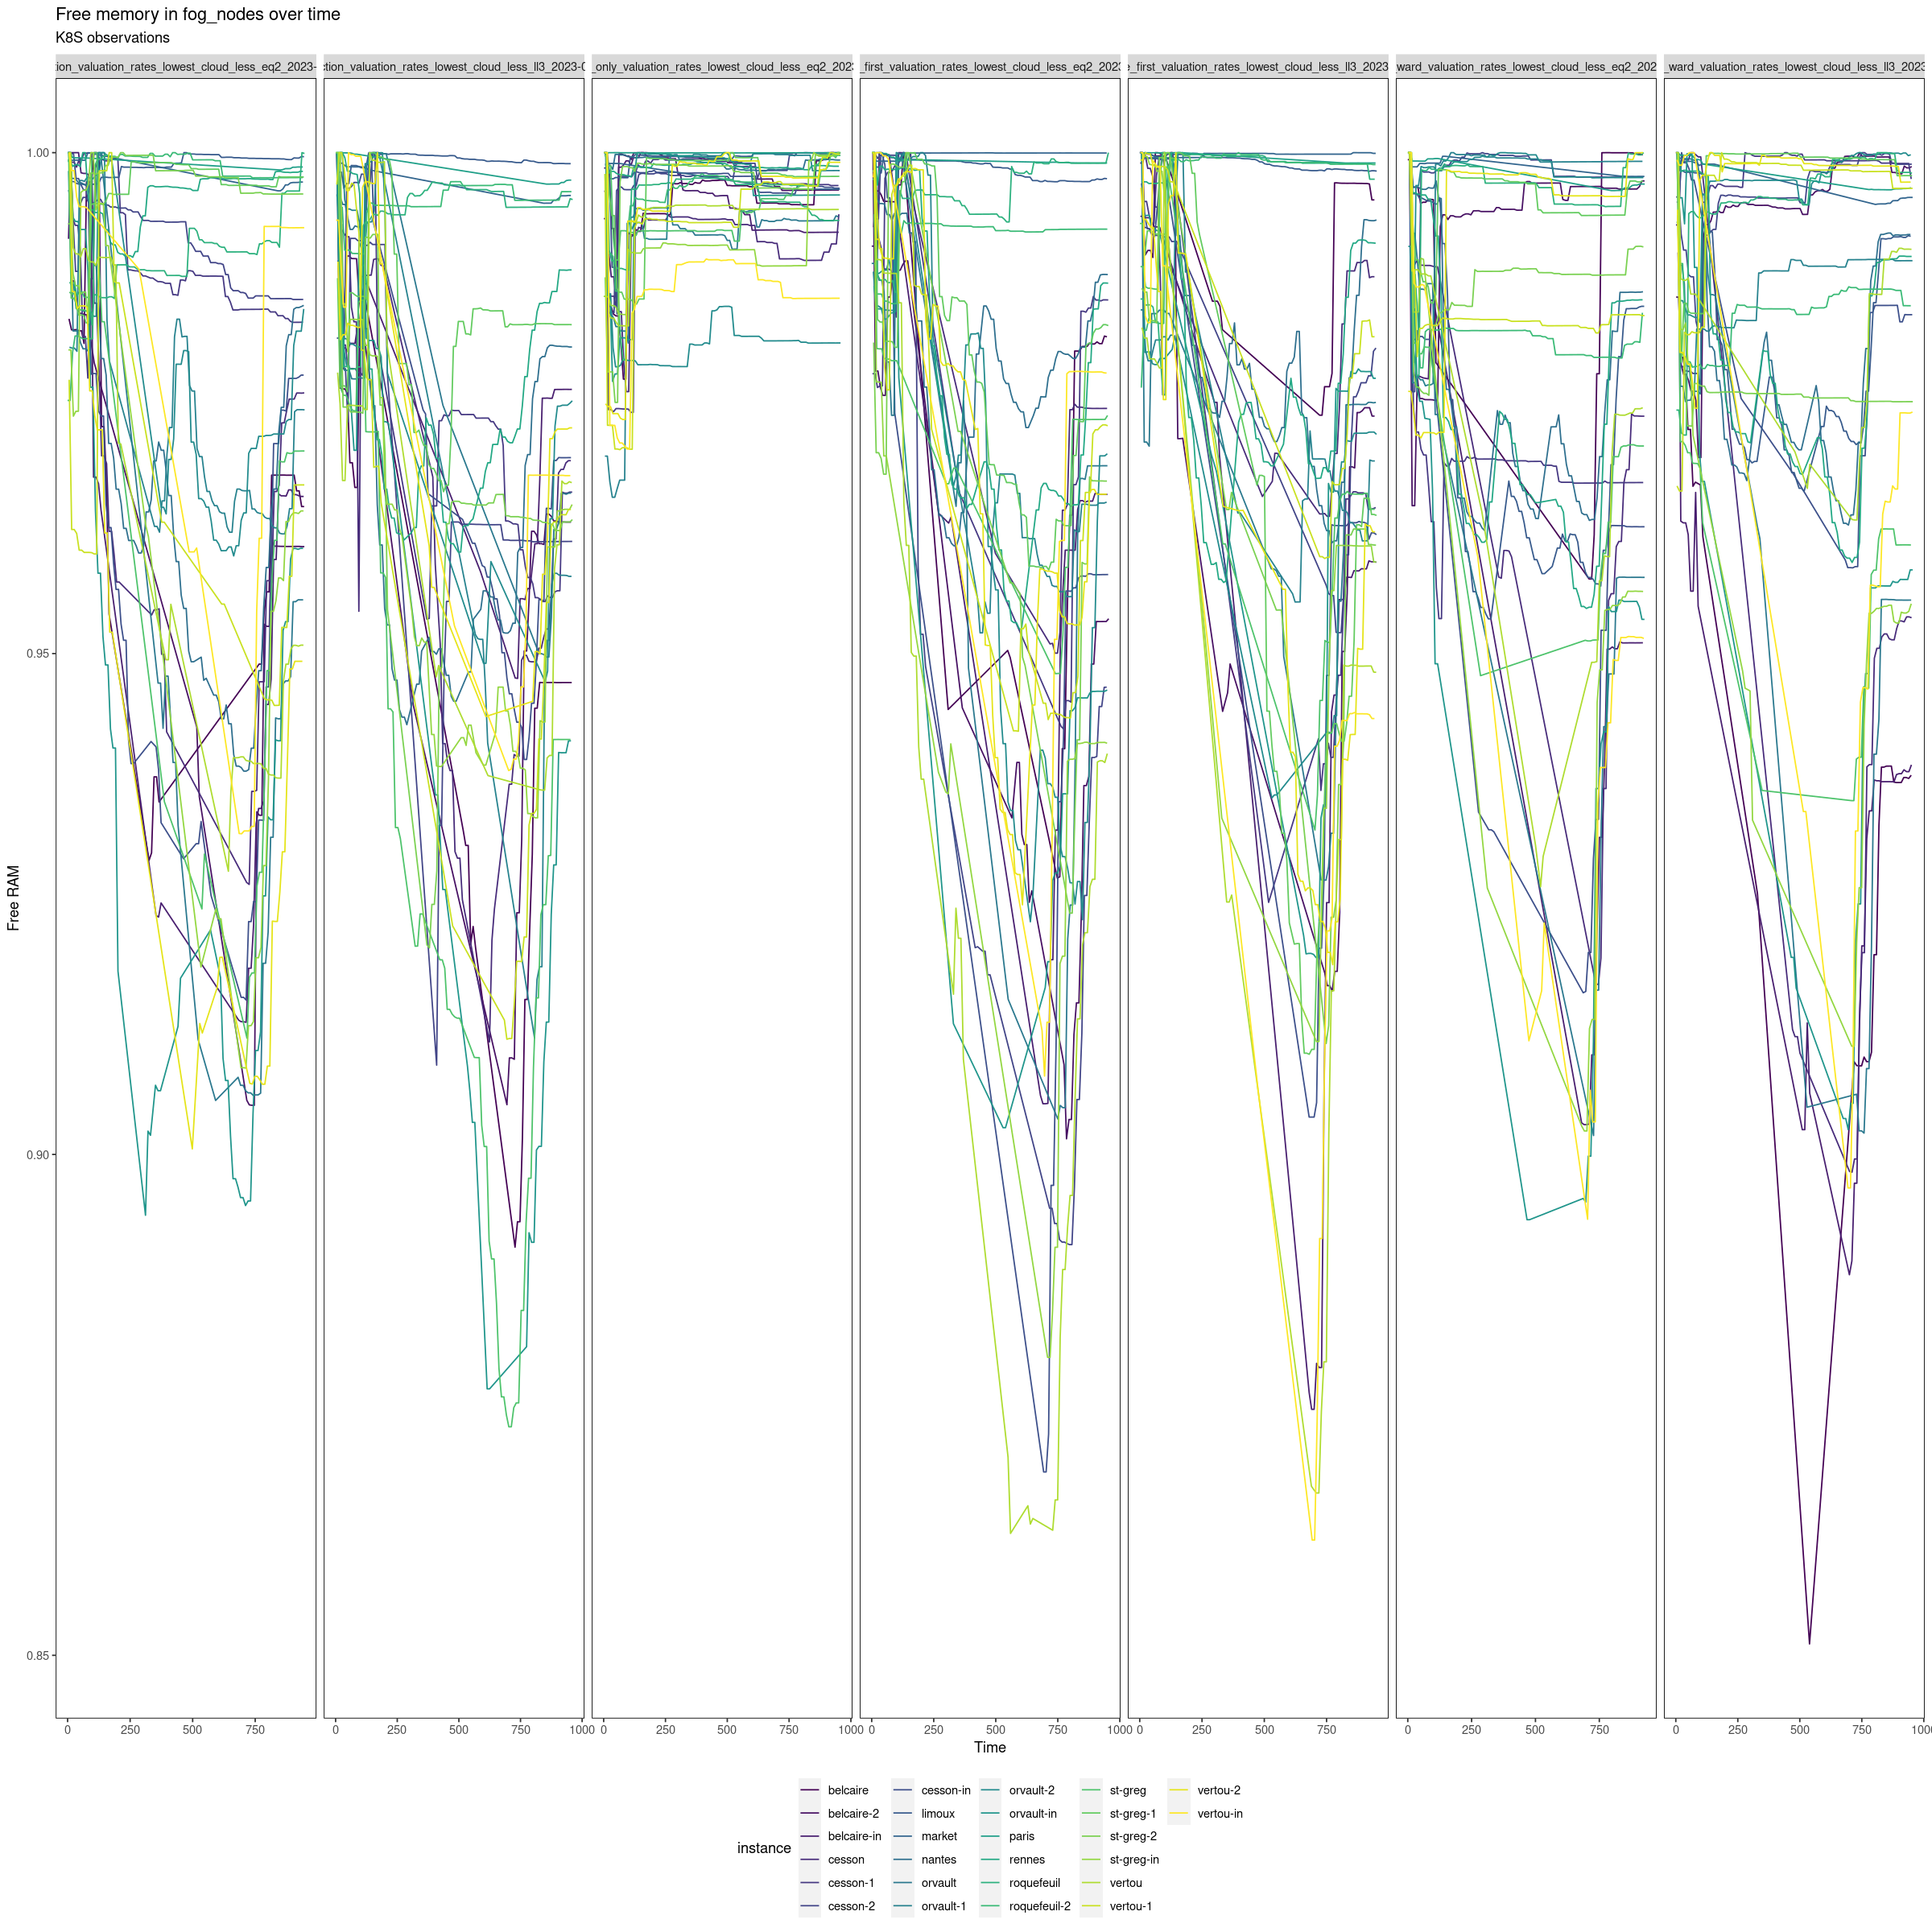

In [66]:
mem_used <- load_csv("fog_node_memory_usage.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_allocatable.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  # geom_area(position = 'stack',  color = "white") +
  geom_line() +
  facet_grid(cols = vars(folder), scale = "free") +
  labs(
    x = "Time",
    y = "Free RAM",
    title = "Free memory in fog_nodes over time",
    subtitle = "K8S observations"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)


Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

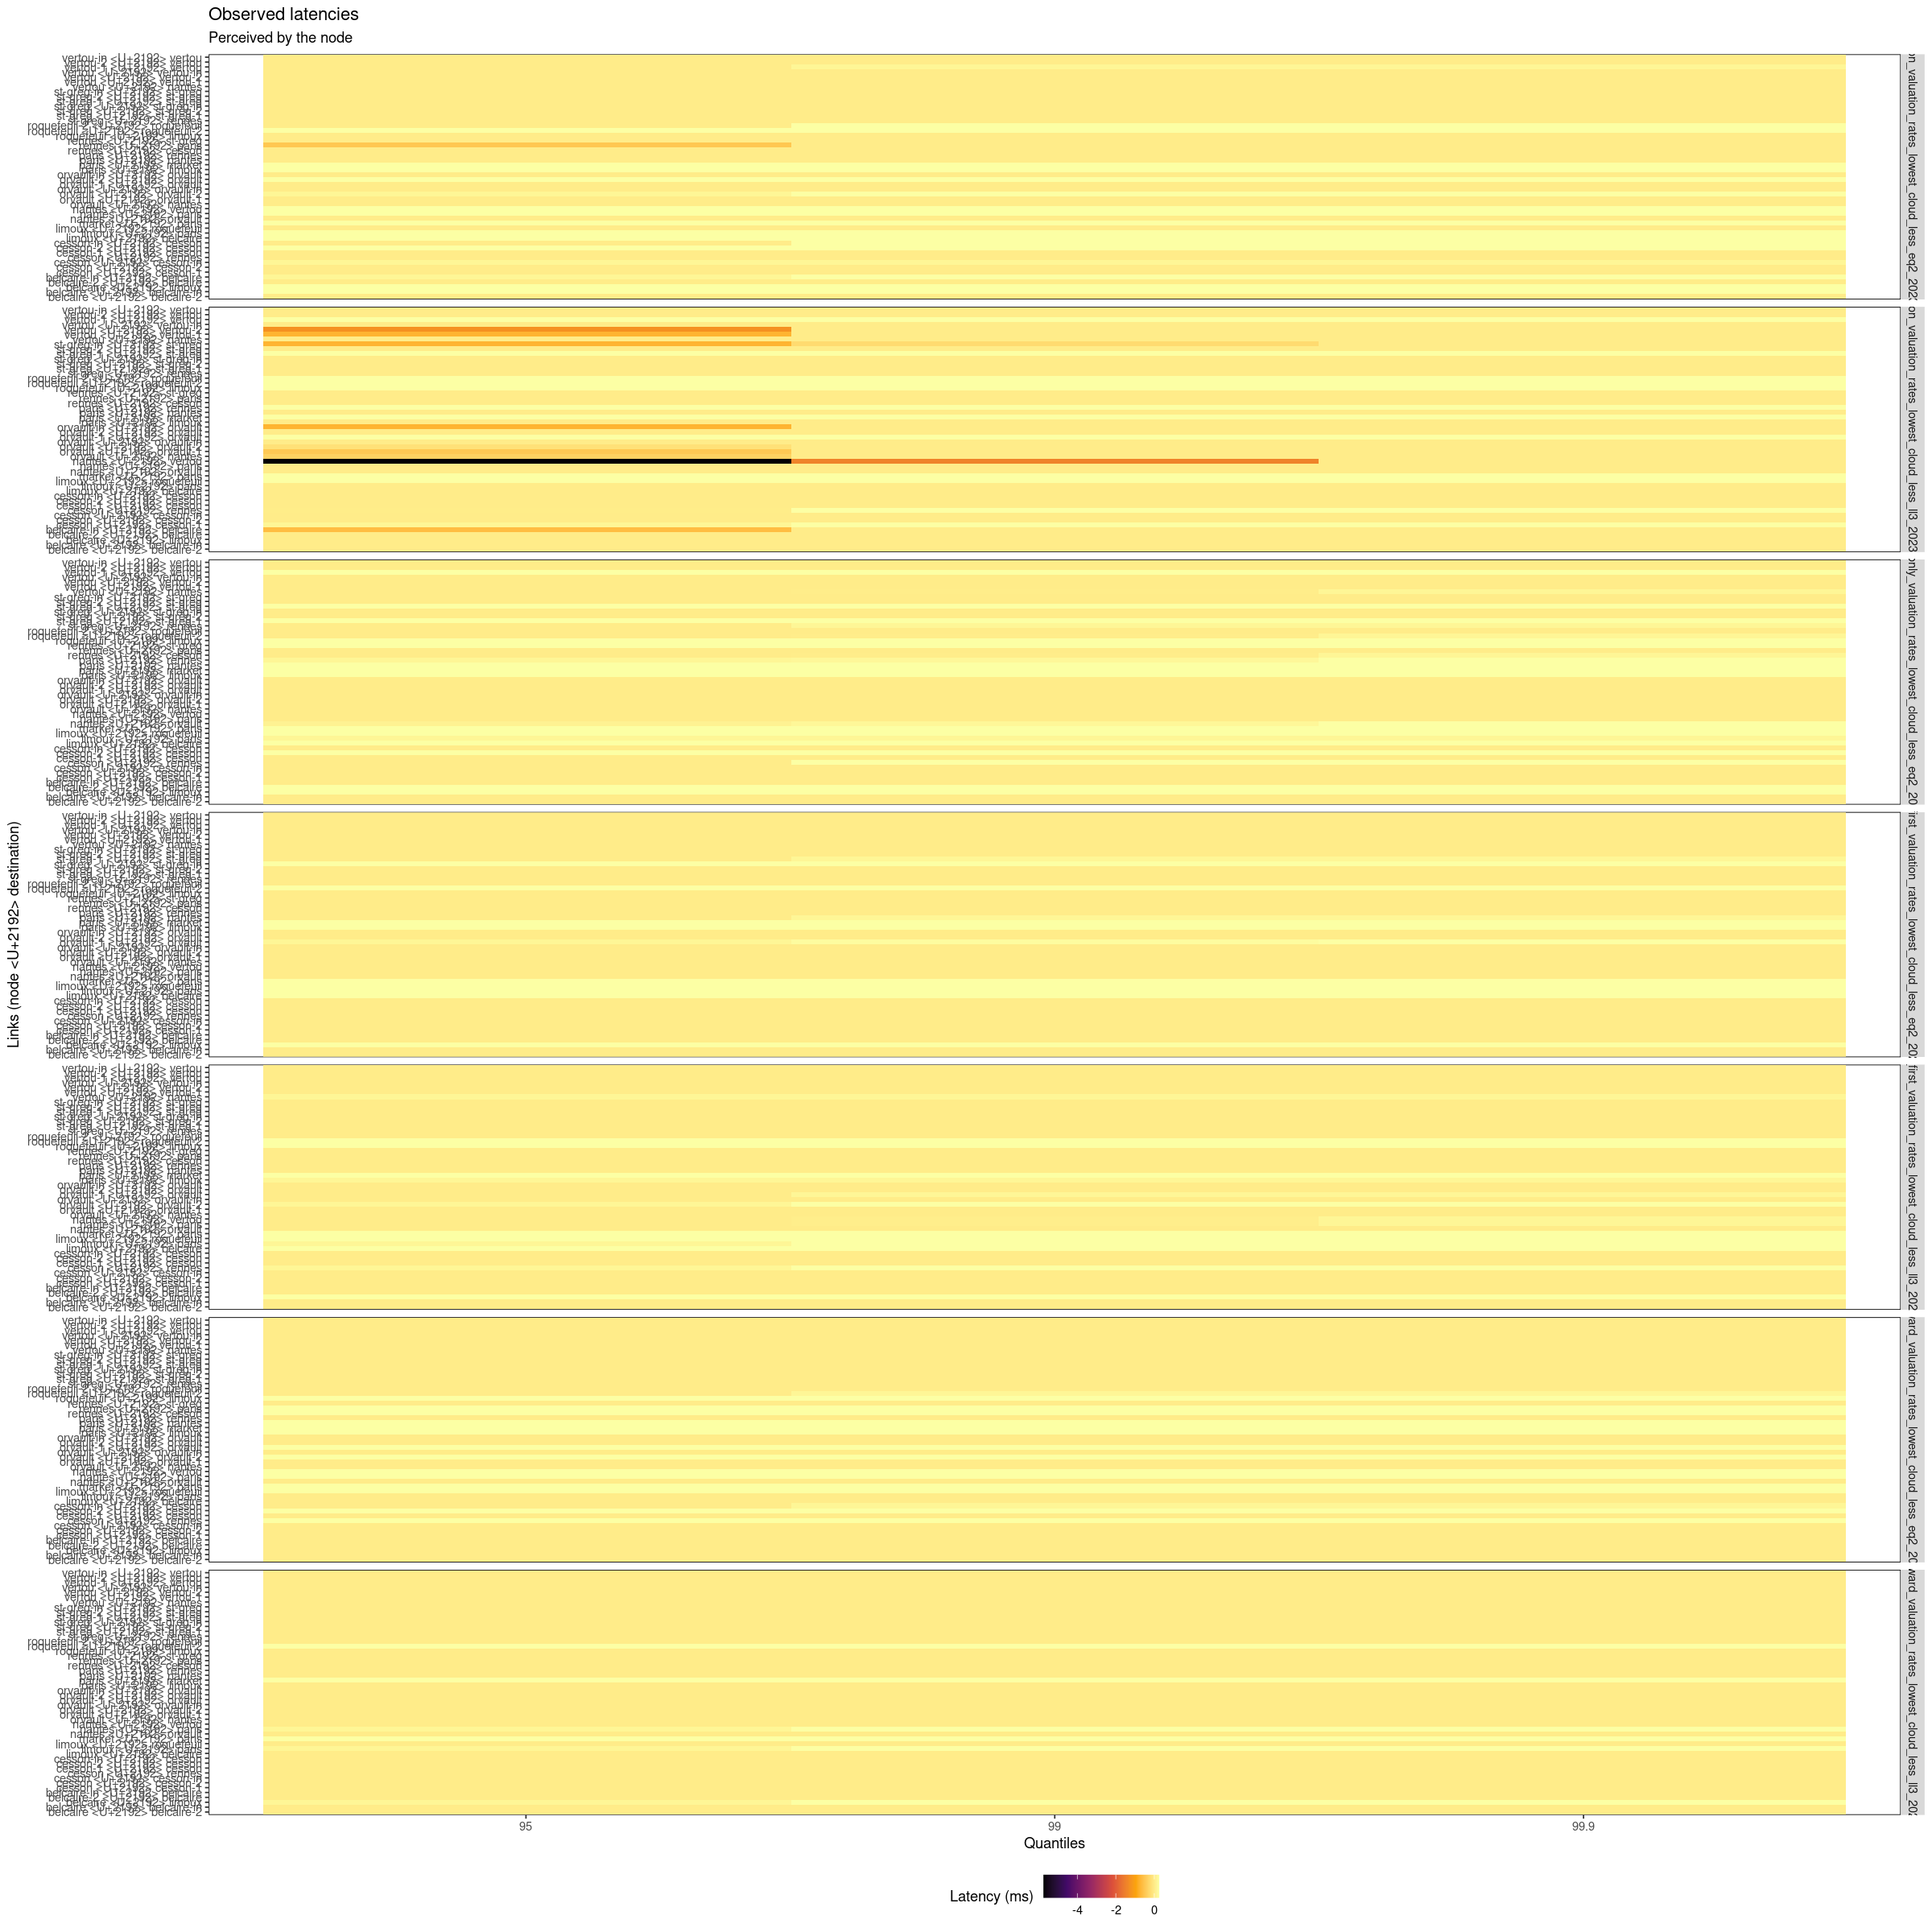

In [67]:
latency <- load_csv("fog_node_neighbors_latency_rolling_avg.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group")) %>%
  mutate(instance_to = destination_name)

p <- c(0.95, 0.99, 0.999)
p_names <- map_chr(p, ~ paste0(.x * 100, ""))
p_funs <- map(p, ~ partial(quantile, probs = .x, na.rm = TRUE)) %>%
  set_names(nm = p_names)

quantiles <- latency %>%
  mutate(value = value * 1000) %>%
  group_by(instance, instance_to, folder) %>%
  summarize_at(vars(value), funs(!!!p_funs)) %>%
  pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
  mutate(diff = value - max(graph_matrix[instance, instance_to], graph_matrix[instance_to, instance])) %>%
  {
    .
  }

quantiles %>%
  ggplot(
    aes(
      y = factor(str_replace(interaction(instance, instance_to), "\\.", " <U+2192> "), ordered = TRUE),
      x = quantile,
      fill = diff,
    )
  ) +
  geom_raster() +
  # geom_text(aes(label=round(diff)), color = "white", alpha=.7, size = 3) +
  scale_fill_viridis_c(option = "inferno") + # trans = 'pseudo_log',
  # scale_fill_gradient2(low = "black", high = "white") +
  facet_grid(rows = vars(folder), scale = "free") +
  labs(
    x = "Quantiles",
    y = "Links (node <U+2192> destination)",
    title = "Observed latencies",
    subtitle = "Perceived by the node",
    fill = "Latency (ms)"
  )


## Bids

In [68]:
functions <- load_csv("market_refused_functions.csv") %>%
    prepare() %>%
    mutate(refused = value) %>%
    select(-c(name.x, value))

functions <- load_csv("market_provisioned_functions.csv") %>%
    prepare() %>%
    mutate(provisioned = value) %>%
    select(-c(name.x, value)) %>%
    inner_join(functions, by = c("instance", "job", "timestamp", "folder", "metric_group", "name.y")) %>%
    select(-c(instance, job, name.y)) %>%
    group_by(folder, metric_group) %>%
    summarise(provisioned = max(provisioned), refused = max(refused)) %>%
    mutate(total = provisioned + refused) %>%
    {
        .
    }

head(functions)


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


folder                                                                   
1 metrics_auction_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-22   
2 metrics_auction_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-05   
3 metrics_cloud_only_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-33
4 metrics_edge_first_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-26
5 metrics_edge_first_valuation_rates_lowest_cloud_less_ll3_2023-03-29-16-00
6 metrics_edge_ward_valuation_rates_lowest_cloud_less_eq2_2023-03-29-15-25 
  metric_group provisioned refused total
1 auction      593         407     1000 
2 auction      658         342     1000 
3 cloud_only   155         845     1000 
4 edge_first   475         525     1000 
5 edge_first   525         475     1000 
6 edge_ward    654         346     1000

In [69]:
# provisioned <- functions %>%
#     extract_function_name_info() %>%
#     select(-total) %>%
#     gather(type, value, -c(folder, metric_group))


# provisioned %>%
#     ggplot(aes(
#         x = metric_group,
#         y = value,
#         fill = factor(str_replace(interaction(type, load_type, latency_type), "\\.", ", ")),
#         group = folder
#     )) +
#     # geom_col(position = position_dodge2(preserve = "single")) +
#     geom_col() +
#     # geom_col(position = position_dodge()) +
#     # geom_boxplot() +
#     # facet_grid(cols = vars(type)) +
#     labs(x = "Deployments", y = "functions", title = "Deployed functions", fill = "State of the functions") +
#     scale_color_viridis(discrete = TRUE, option = "D") +
#     scale_fill_viridis(discrete = TRUE) +
#     theme(
#         axis.text.x = element_text(angle = 45)
#     )


In [100]:
sla_turnover <- load_csv("fog_node_sla_seen.csv") %>% prepare()

`summarise()` has grouped output by 'sla_id', 'folder', 'metric_group'. You can override using the `.groups` argument.


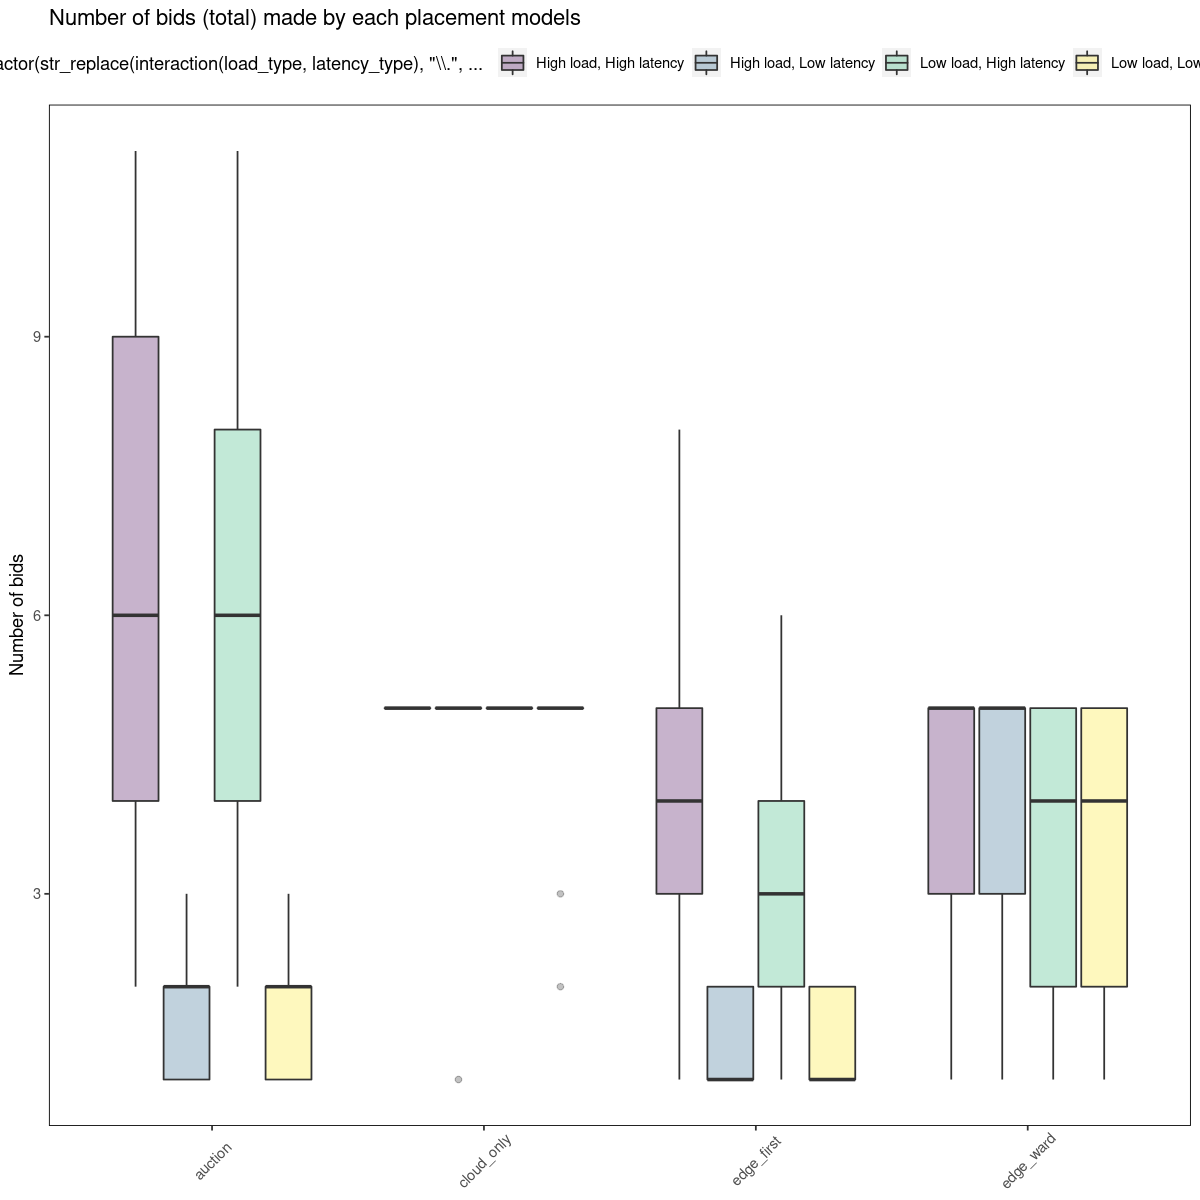

In [114]:
sla_turnover_processed <- sla_turnover %>%
  select(sla_id, folder, metric_group, instance, function_name) %>%
  distinct() %>%
  group_by(sla_id, folder, metric_group, function_name) %>%
  summarise(n = n()) %>%
  extract_function_name_info() %>%
  # group_by(metric_group, folder, load_type, latency_type) %>%
  # summarise(mean_folder = mean(n_folder), min_folder = min(n_folder), max_folder = max(n_folder)) %>%
  # group_by(metric_group, load_type, latency_type) %>%
  # summarise(mean = mean(mean_folder), min = min(min_folder), max = max(max_folder)) %>%
  {
    .
  }

# sla_turnover_processed
fig(10,10)
sla_turnover_processed %>%
  ggplot(
    aes(
      x = metric_group,
      y = n,
      # fill = as.character(level),
      fill = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),

      # group = metric_group
    )
  ) +
  labs(
    title = "Number of bids (total) made by each placement models",
    x = "placement models",
    y = "Number of bids"
  ) +
  geom_boxplot(alpha=0.3, position = position_dodge2()) +
  # geom_errorbar(aes(ymin = min, ymax = max), position = position_dodge2()) +
  scale_color_viridis(discrete = TRUE, option = "E") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    legend.position = "top",
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45)
  )
# bids_function_graph


In [70]:
bids_raw <- load_csv("fog_node_bids.csv") %>% prepare()

bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value, folder))

bids_won <- bids_won_raw %>%
  group_by(function_name, folder) %>%
  slice(which.min(value)) %>%
  group_by(instance, folder) %>%
  summarise(n = n()) %>%
  # group_by(folder ) %>%
  complete(folder, fill = list(n = 0, instance = "tto")) %>%
  {
    .
  }


`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'sla_id', 'folder', 'metric_group', 'latency_type'. You can override using the `.groups` argument.


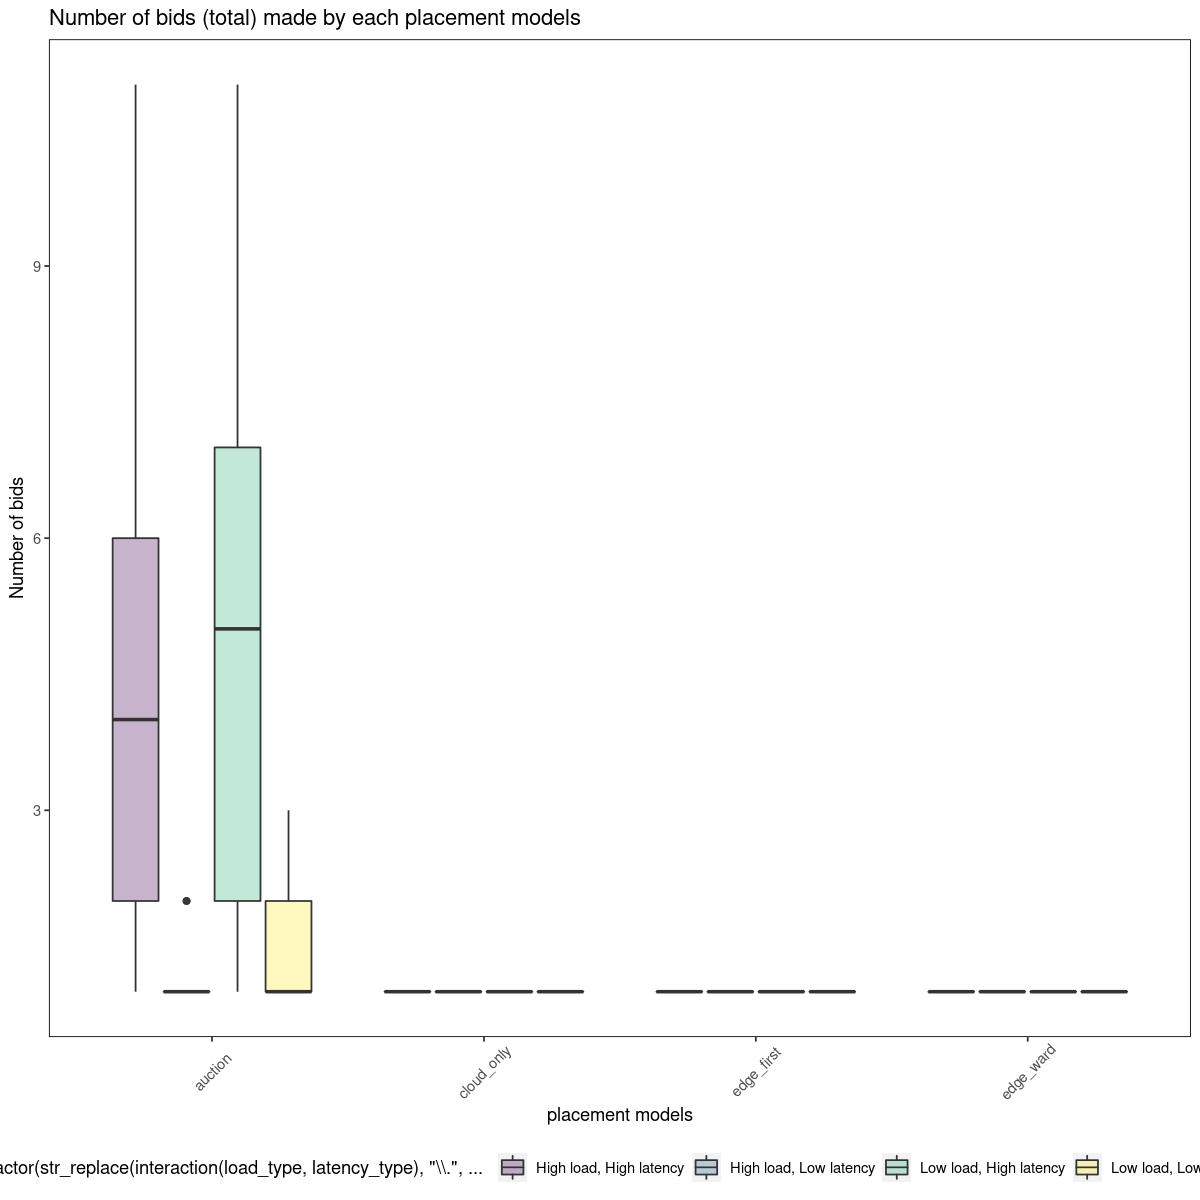

In [136]:
bids_function <- bids_raw %>%
  # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
  select(instance, folder, metric_group, function_name, sla_id, bid_id) %>%
  ungroup() %>%
  distinct() %>%
  # inner_join(bids_won_function %>% ungroup() %>% select(winner, bid_id), by = c("bid_id")) %>%
  extract_function_name_info() %>%
  # filter(metric_group=="auction") %>%
  # filter(function_index==1) %>%
  # filter(bid_id == "f0a35d9f-a94c-4709-8e73-edf445f7c62a") %>%
  # filter(function_name == "echo-125-71-100-100-high-low-50-50") %>%
  group_by(sla_id, folder, metric_group, latency_type, load_type) %>%
  summarise(n = n()) %>%
  # group_by(metric_group, folder, latency_type, load_type) %>%
  # summarise(n_folder = mean(n_by_sla), min_n_folder = min(n_by_sla), max_n_folder = max(n_by_sla)) %>%
  # group_by(metric_group, latency_type, load_type) %>%
  # summarise(n = mean(n_folder), min = min(min_n_folder), max = max(max_n_folder)) %>%
  {
    .
  }

# bids_function

bids_function_graph <- bids_function %>%
  ggplot(
    aes(
      x = metric_group,
      y = n,
      # fill = as.character(level),
      fill = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),

      # group = metric_group
    )
  ) +
  labs(
    title = "Number of bids (total) made by each placement models",
    x = "placement models",
    y = "Number of bids"
  ) +
  geom_boxplot(alpha=0.3, position = position_dodge2()) +
  # geom_errorbar(aes(ymin = min, ymax = max), position = position_dodge2()) +
  scale_color_viridis(discrete = TRUE, option = "E") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    # legend.position = "top",
    # axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45)
  )
bids_function_graph


In [143]:
bids_won_function <- bids_raw %>%
  group_by(sla_id, function_name, folder, metric_group) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function %>% filter(sla_id=="466f56bb-9fa5-443d-9862-86d8c13a01bf"))

`summarise()` has grouped output by 'function_name', 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'latency_type', 'load_type'. You can override using the `.groups` argument.


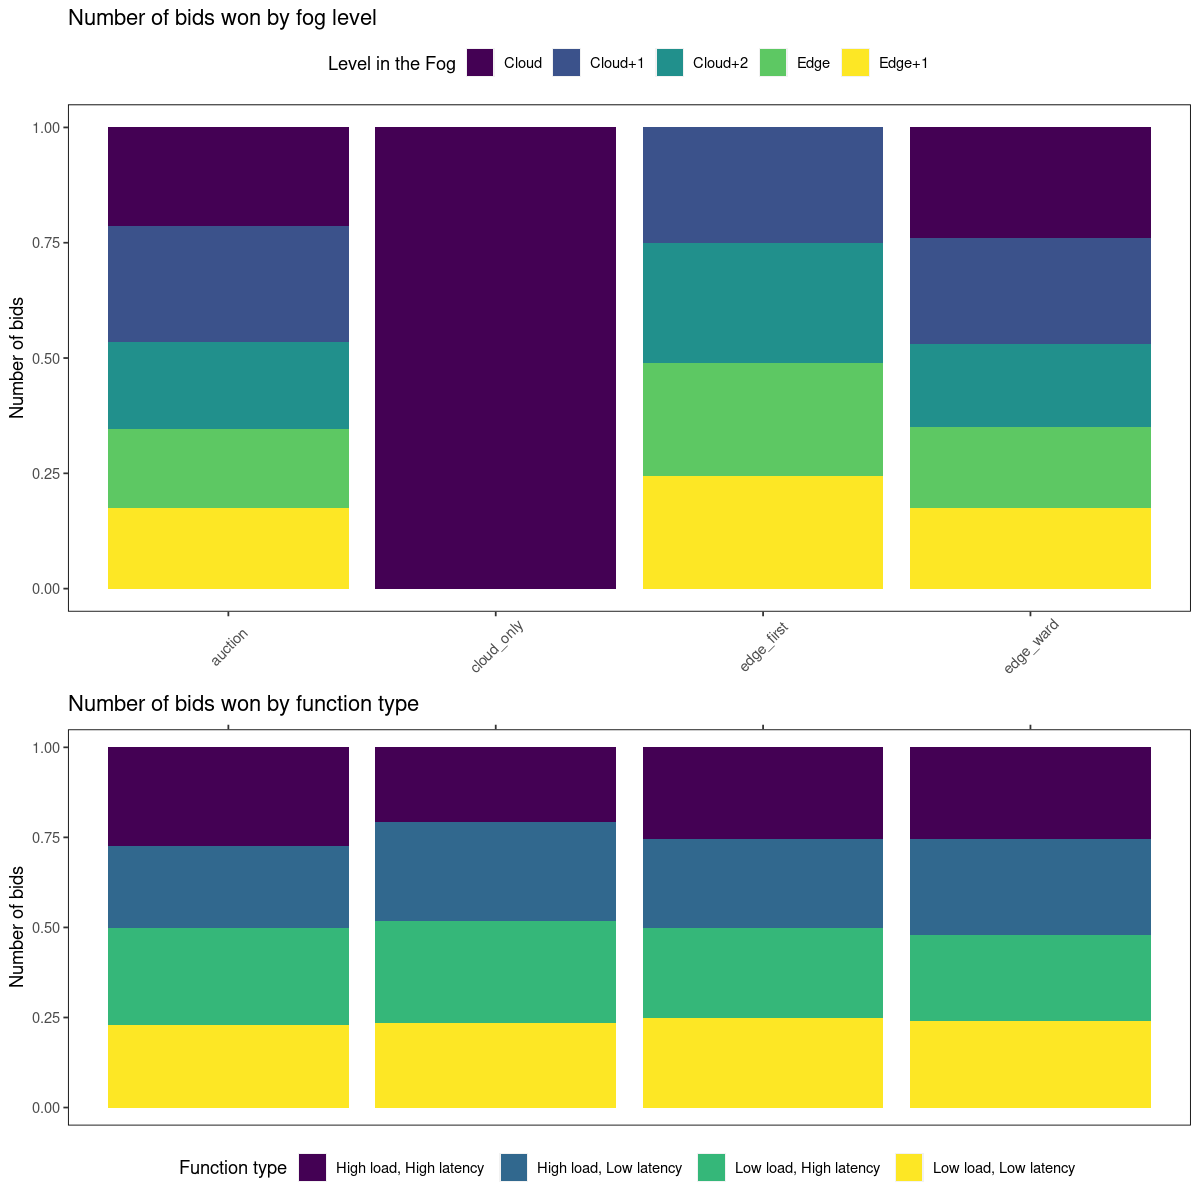

In [145]:
winner_gains_raw <- bids_won_function %>%
  # distinct() %>%
  # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  select(function_name, sla_id, folder, metric_group, winner) %>%
  group_by(function_name, folder, metric_group, winner) %>%
  summarise(n_bids_won = n()) %>%
  extract_function_name_info() %>%
  # ungroup() %>%
  # inner_join(functions %>% select(-total), by = c("level", "folder", "metric_group")) %>%
  # mutate(total = total / provisioned)
  {
    .
  }

# head(winner_gains_raw)

winner_gains_levels <- winner_gains_raw %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  group_by(metric_group, level) %>%
  summarise(mean_bids_won_level = mean(n_bids_won)) %>%
  {
    .
  }

winner_gains <- winner_gains_raw %>%
  group_by(latency_type, load_type, metric_group) %>%
  summarise(mean_bids_won_fn_type = mean(n_bids_won)) %>%
  {
    .
  }

# head(bids_won_function)

winner_gains_graph_levels <- winner_gains_levels %>%
  ggplot(aes(
    x = metric_group,
    y = mean_bids_won_level,
    # fill = as.character(level),
    fill = level,
    # group = metric_group
  )) +
  # geom_col(position = position_dodge2(preserve = "single")) +
  geom_col(position = position_fill()) +
  labs(
    x = "Placement models",
    y = "Number of bids",
    title = "Number of bids won by fog level",
    fill = "Level in the Fog"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    legend.position = "top",
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45)
  )

winner_gains_graph <- winner_gains %>%
  ggplot(aes(
    x = metric_group,
    y = mean_bids_won_fn_type,
    # fill = as.character(level),
    fill = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),
    # group = metric_group
  )) +
  # geom_col(position = position_dodge2(preserve = "single")) +
  geom_col(position = position_fill()) +
  scale_x_discrete(position = "top") +
  labs(
    x = "Placement models",
    y = "Number of bids",
    title = "Number of bids won by function type",
    fill = "Function type"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    strip.background = element_blank(),
    strip.text.x = element_blank()
  )
aligned <- align_plots(winner_gains_graph_levels, winner_gains_graph, align = "v")
cowplot::plot_grid(aligned[[1]], aligned[[2]], ncol = 1, rel_heights = c(1, 0.75))


`summarise()` has grouped output by 'function_name', 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'latency_type', 'load_type'. You can override using the `.groups` argument.


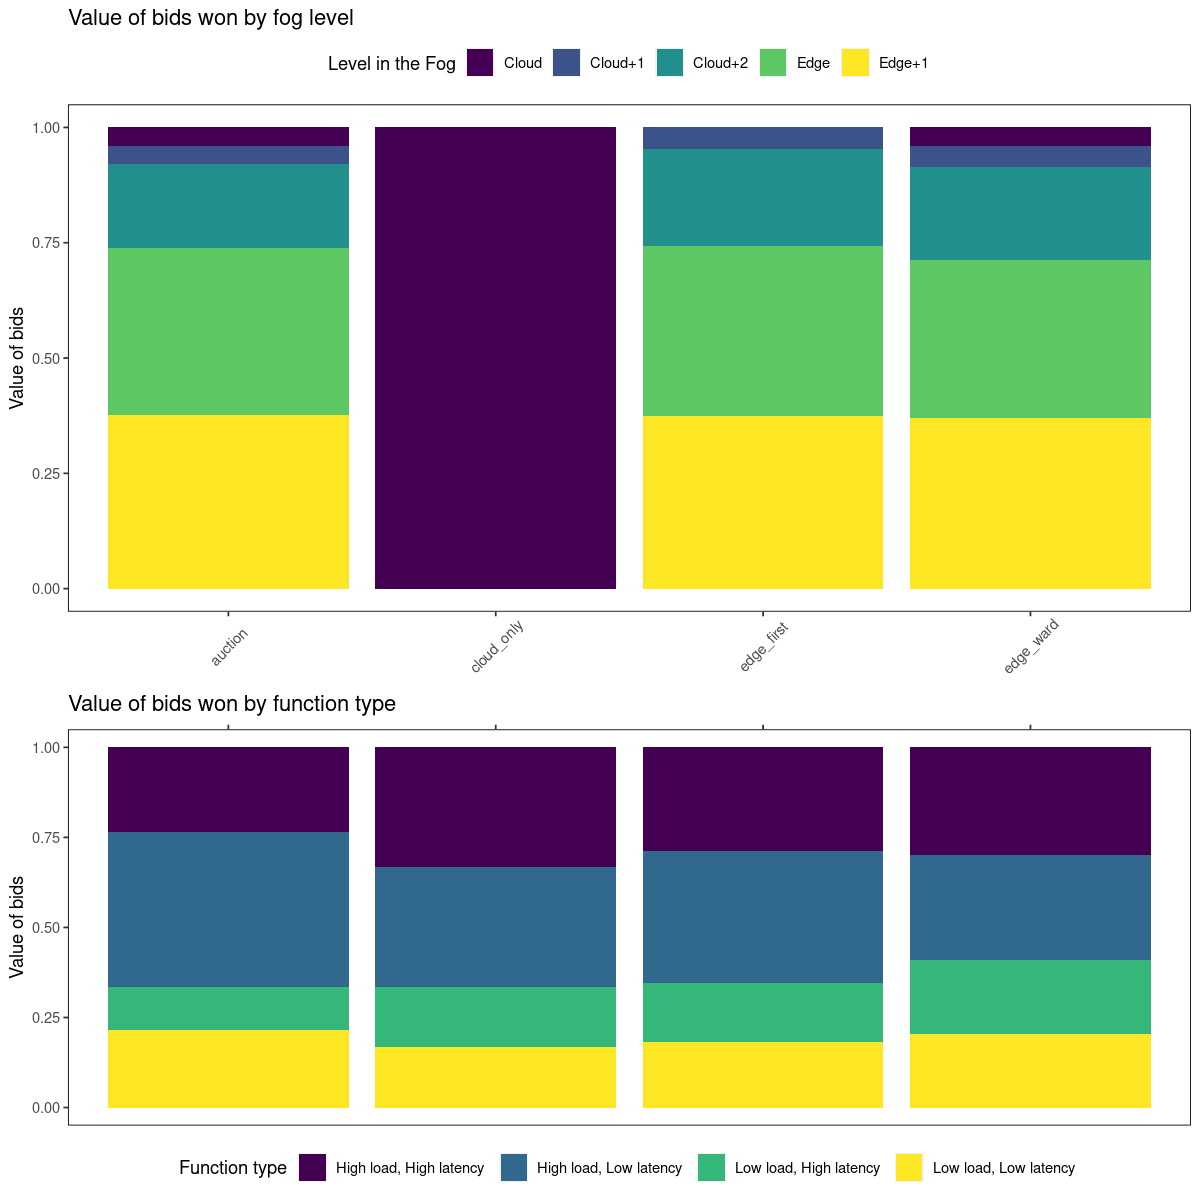

In [146]:
winner_gains_raw <- bids_won_function %>%
  # distinct() %>%
  # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  select(function_name, sla_id, folder, metric_group, winner, value) %>%
  group_by(function_name, folder, metric_group, winner) %>%
  summarise(value_bids_won = mean(value)) %>%
  extract_function_name_info() %>%
  # ungroup() %>%
  # inner_join(functions %>% select(-total), by = c("level", "folder", "metric_group")) %>%
  # mutate(total = total / provisioned)
  {
    .
  }

# head(winner_gains_raw)

winner_gains_levels <- winner_gains_raw %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  group_by(metric_group, level) %>%
  summarise(mean_value_bids_won_level = mean(value_bids_won)) %>%
  {
    .
  }

winner_gains <- winner_gains_raw %>%
  group_by(latency_type, load_type, metric_group) %>%
  summarise(mean_value_bids_won_fn_type = mean(value_bids_won)) %>%
  {
    .
  }

# head(bids_won_function)

winner_gains_graph_levels <- winner_gains_levels %>%
  ggplot(aes(
    x = metric_group,
    y = mean_value_bids_won_level,
    # fill = as.character(level),
    fill = level,
    # group = metric_group
  )) +
  # geom_col(position = position_dodge2(preserve = "single")) +
  geom_col(position = position_fill()) +
  labs(
    x = "Placement models",
    y = "Value of bids",
    title = "Value of bids won by fog level",
    fill = "Level in the Fog"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    legend.position = "top",
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45)
  )

winner_gains_graph <- winner_gains %>%
  ggplot(aes(
    x = metric_group,
    y = mean_value_bids_won_fn_type,
    # fill = as.character(level),
    fill = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),
    # group = metric_group
  )) +
  # geom_col(position = position_dodge2(preserve = "single")) +
  geom_col(position = position_fill()) +
  scale_x_discrete(position = "top") +
  labs(
    x = "Placement models",
    y = "Value of bids",
    title = "Value of bids won by function type",
    fill = "Function type"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    strip.background = element_blank(),
    strip.text.x = element_blank()
  )
aligned <- align_plots(winner_gains_graph_levels, winner_gains_graph, align = "v")
cowplot::plot_grid(aligned[[1]], aligned[[2]], ncol = 1, rel_heights = c(1, 0.75))


## Latencies and SLAs

In [73]:
# echo_sum <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
#   prepare()

# echo_count <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
#   prepare()

echo_bucket <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_bucket.csv") %>%
  prepare() %>%
  mutate(function_name = tag)

latencies <- echo_bucket %>%
  select(function_name, folder) %>%
  distinct() %>%
  extract_function_name_info() %>%
  select(latency, folder)


In [74]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


Warning message in min.default(structure(numeric(0), tzone = "", class = c("POSIXct", :
“aucun argument trouvé pour min ; Inf est renvoyé”
Warning message:
“Unknown or uninitialised column: `function_name`.”


In [75]:
echo_bucket <- echo_bucket %>%
    mutate(value_bucket = value) %>%
    mutate(le = ifelse(le == "+Inf", Inf, as.numeric(le))) %>%
    {
        .
    }

average <- echo_bucket %>%
    extract_function_name_info() %>%
    mutate(latency = as.numeric(latency) / 1000) %>%
    mutate(load = 1000 / as.numeric(period)) %>%
    {
        .
    }


In [90]:
average_sum <- average %>%
    select(load, sla_id, function_name, folder, le, value_bucket, latency, timestamp, metric_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    inner_join(bids_won_function %>% select(function_name, metric_group, folder, winner), by = c("function_name", "folder", "metric_group")) %>%
    # select(-function_name) %>%
    arrange(desc(timestamp), .by_group = TRUE) %>%
    group_by(function_name, sla_id, timestamp, winner, load, folder, le, latency, metric_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    filter(row_number() == n()) %>% # Last measure
    # select(-timestamp) %>%
    arrange(desc(le), .by_group = TRUE) %>%
    {
        .
    }

# head(average_sum)

under_sla <- average_sum %>%
    mutate(target_offset = round(le - latency, 3)) %>%
    filter(target_offset %in% c(-0.003, -0.002, -0.001, 0, 0.003, 0.002, 0.001)) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, target_offset, metric_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    select(-le) %>%
    {
        .
    }

# under_sla

sla_stats <- average_sum %>%
    filter(le == Inf) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, metric_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    mutate(total = value_bucket) %>%
    select(-c(value_bucket, le)) %>%
    inner_join(under_sla, by = c("sla_id", "timestamp", "function_name", "winner", "load", "folder", "latency", "metric_group", "latency_type", "load_type", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency")) %>%
    mutate(above = total - value_bucket) %>%
    {
        .
    }

# sla_stats


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 9796 rows containing non-finite values (stat_boxplot).”


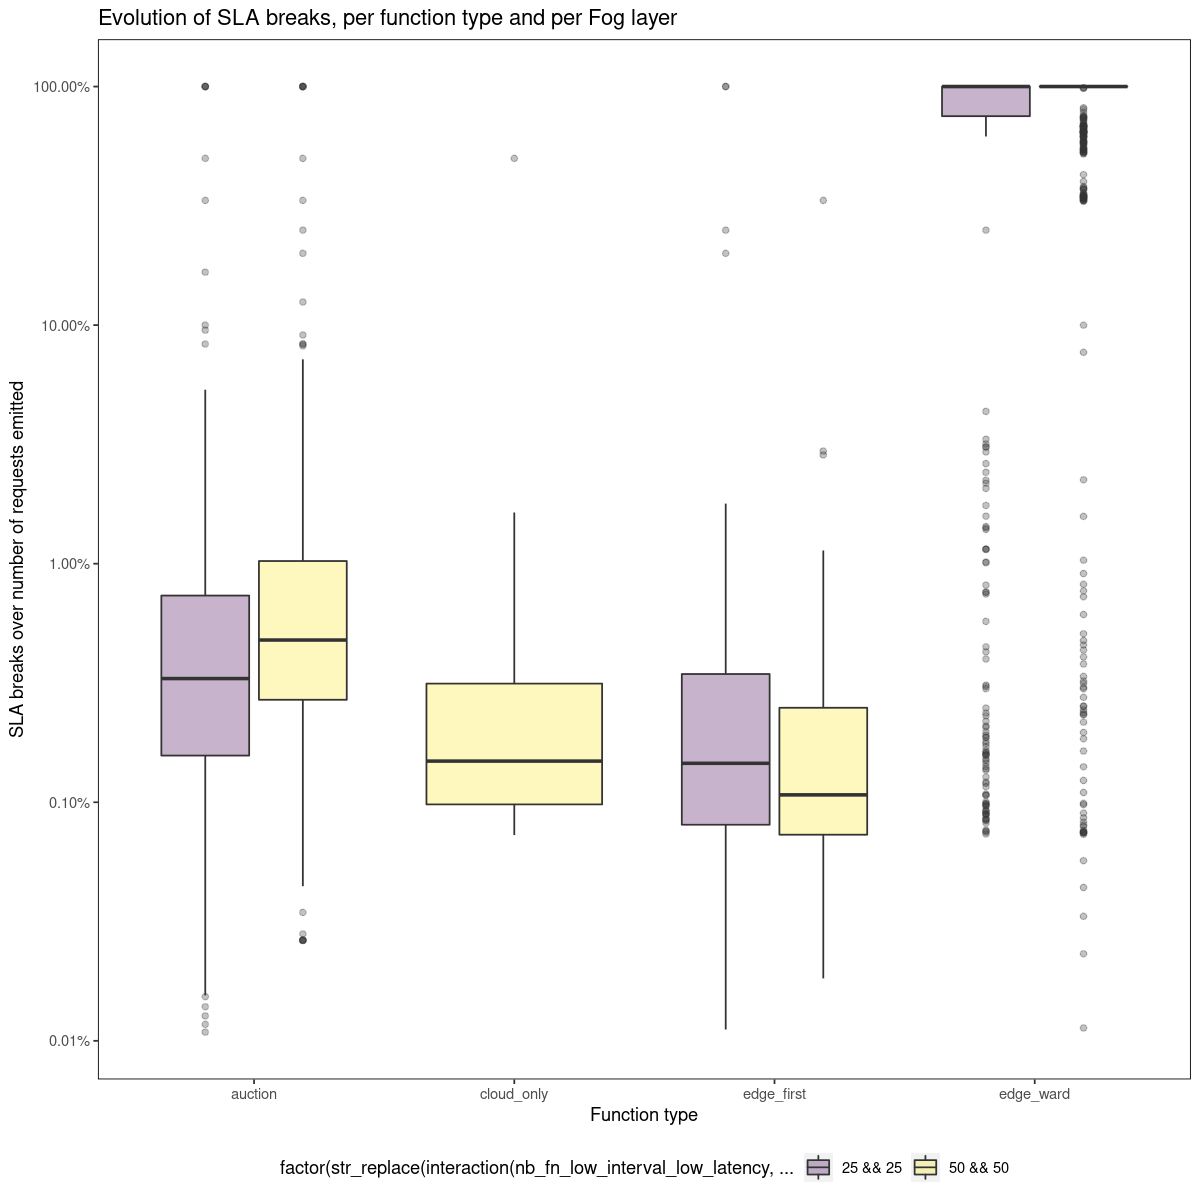

In [159]:
evol_sla_data <- sla_stats %>%
  # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  group_by(sla_id, folder, metric_group, function_name, target_offset, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
  # mutate(timestamp = round(timestamp)) %>%
  # summarize(above = sum(above), respected = sum(value_bucket)) %>%
  # group_by(folder, sla_id, function_name, metric_group, target_offset, latency_type, load_type, level, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
  mutate(percent = above / (above + value_bucket)) %>%
  # group_by(folder, metric_group, target_offset, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
  # summarise(percent = mean(percent)) %>%
  # spread(key = target_offset, value = percent) %>%
  {
    .
  }
# head(evol_sla_data)
fig(10, 10)
evol_sla_data %>%
  filter(target_offset == 0) %>%
  ggplot(
    aes(
      x = metric_group,
      y = percent,
      fill = factor(str_replace(interaction(nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency), "\\.", " && "), ordered = TRUE),
      # fill = metric_group,
      # color = metric_group,
      # group = folder
    )
  ) +
  # geom_col(position = position_dodge2(preserve = "total")) +
  # geom_boxplot(alpha=0.3) +#, position = position_dodge2(preserve = "single")) +
  # geom_violin(trim=FALSE)+
  geom_boxplot(alpha=0.3, position = position_dodge2()) +
  scale_y_log10(label = scales::percent) +
  labs(
    x = "Function type",
    y = "SLA breaks over number of requests emitted",
    title = "Evolution of SLA breaks, per function type and per Fog layer"
  ) +
  # facet_grid(rows = vars(factor(str_replace(interaction(load_type, latency_type), "\\.", " && "), ordered = TRUE))) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  # geom_texthline(aes(yintercept=0.05, label = "5%"),lty = 1, colour= 'red') +
  # geom_texthline(aes(yintercept=0.01, label = "1%"),lty = 2, colour= 'darkorange1') +
  # coord_flip() +
  theme(
    # legend.position = "none",
    # axis.title.x = element_blank()
  )


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 29631 rows containing non-finite values (stat_boxplot).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 29631 rows containing non-finite values (stat_boxplot).”


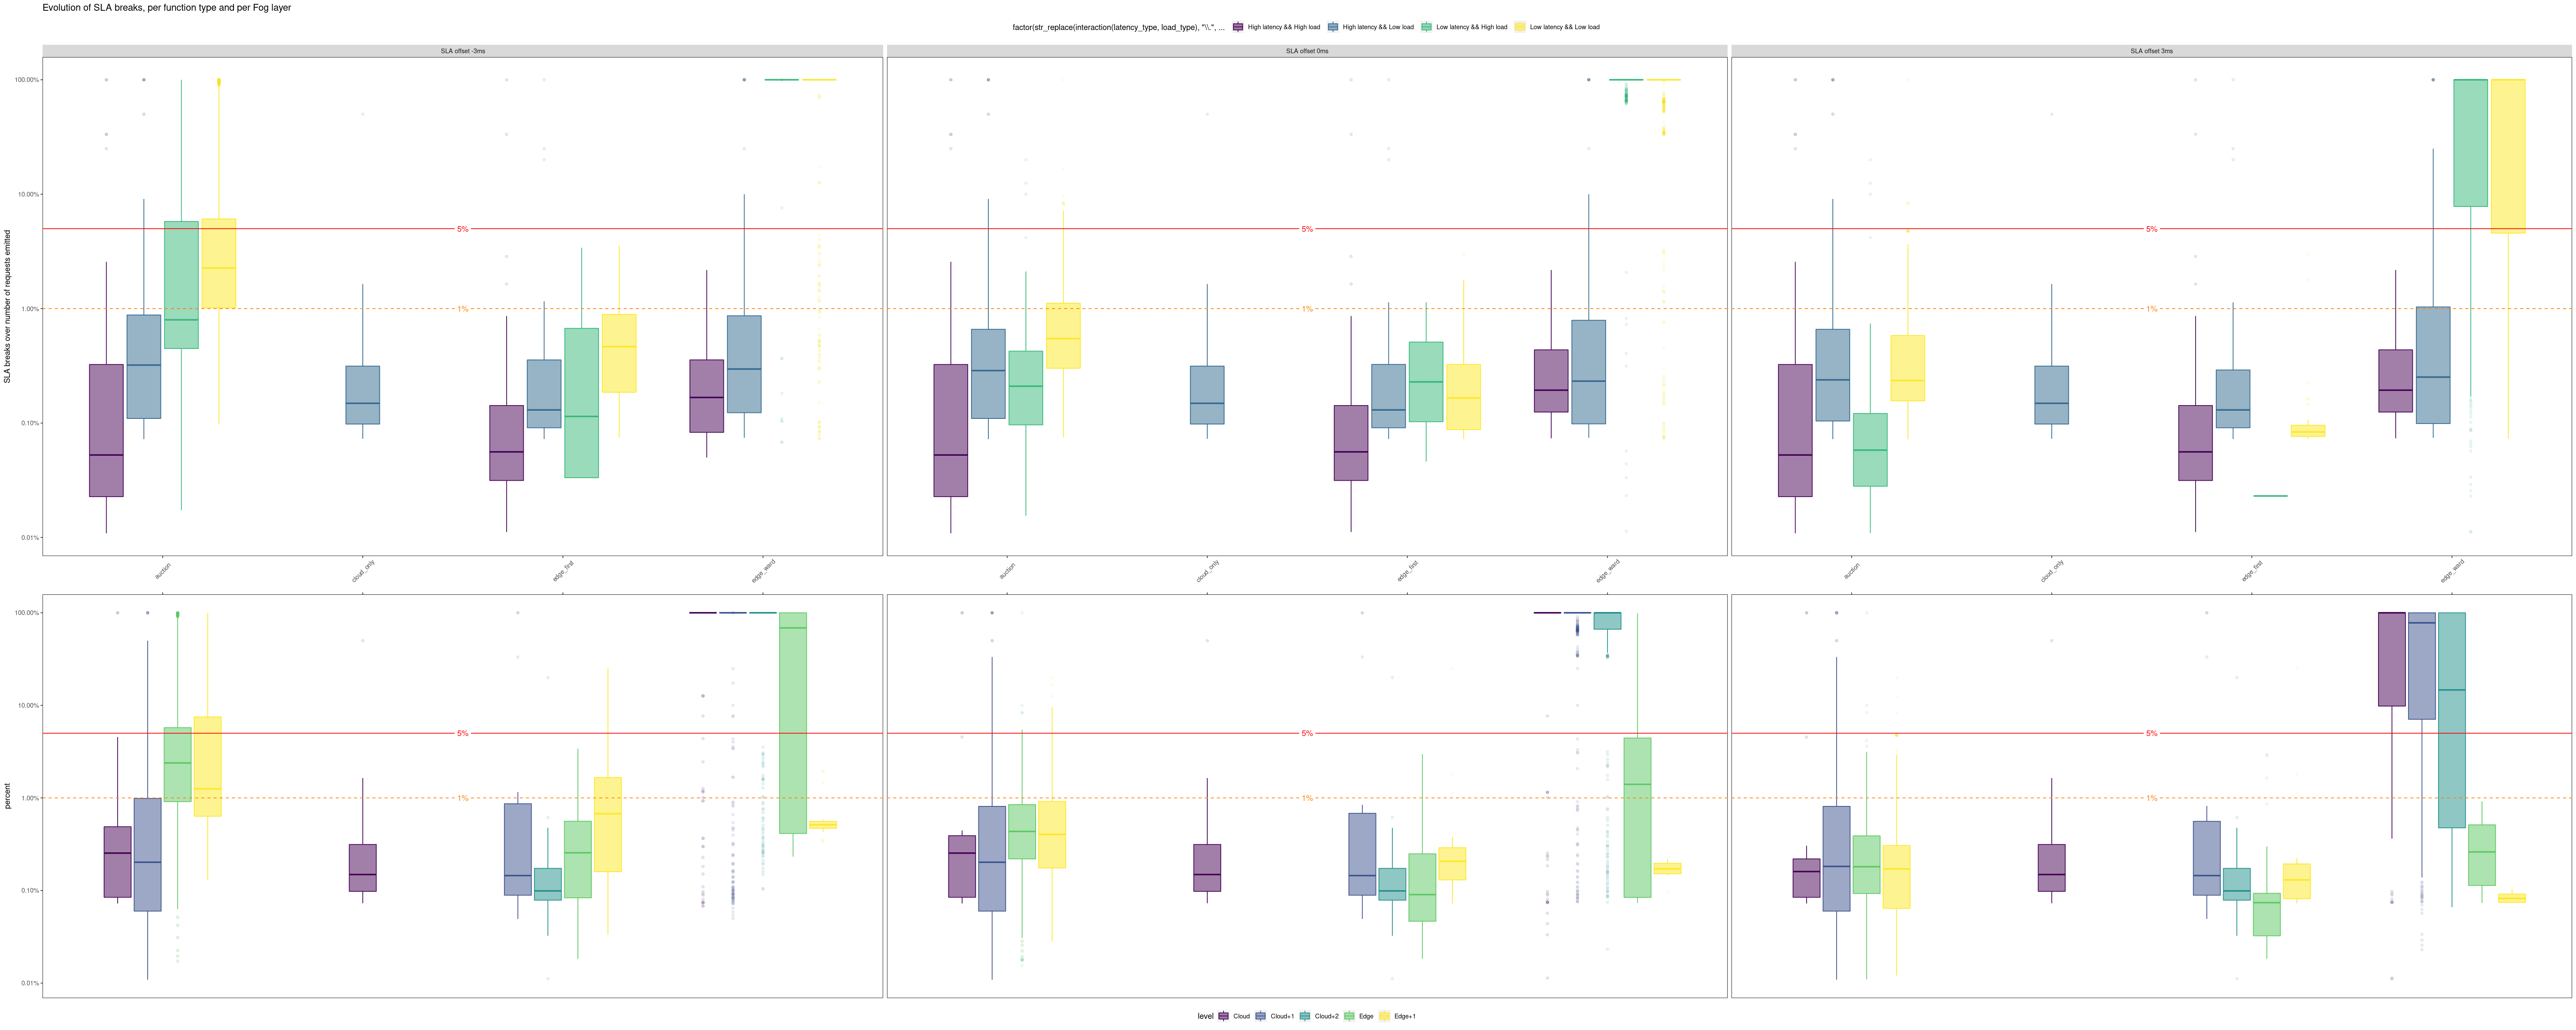

In [95]:
evol_sla_data <- sla_stats %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  group_by(folder, sla_id, metric_group, function_name, target_offset, latency_type, load_type, level) %>%
  mutate(percent = above / (above + value_bucket)) %>%
  group_by(folder, metric_group, target_offset, latency_type, load_type, level) %>%
  filter(target_offset %in% c(-0.003, 0, 0.003)) %>%
  mutate(target_offset = paste("SLA offset ", as.character(target_offset * 1000), "ms", sep = "")) %>%
  {
    .
  }
# head(evol_sla_data)

evol_sla_data_by_functions <- evol_sla_data %>%
  # filter(target_offset == 0) %>%
  ggplot(
    aes(
      x = metric_group,
      y = percent,
      fill = factor(str_replace(interaction(latency_type, load_type), "\\.", " && "), ordered = TRUE),
      color = factor(str_replace(interaction(latency_type, load_type), "\\.", " && "), ordered = TRUE),
    )
  ) +
  geom_boxplot(alpha = 0.5, outlier.alpha = .1, position = position_dodge2(preserve = "single")) +
  scale_y_log10(label = scales::percent) +
  labs(
    x = "Function type",
    y = "SLA breaks over number of requests emitted",
    title = "Evolution of SLA breaks, per function type and per Fog layer"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  geom_texthline(aes(yintercept = 0.05, label = "5%"), lty = 1, colour = "red") +
  geom_texthline(aes(yintercept = 0.01, label = "1%"), lty = 2, colour = "darkorange1") +
  # stat_summary(geom = 'text', aes(y = mean(percent), label = metric_group),
  #   position = position_dodge2(width = 1, preserve = "single")) +
  # geom_text(
  #   # data = evol_sla_data %>% ungroup() %>% select(latency_type, load_type, metric_group, folder, percent) %>% distinct(),
  #   aes(y = mean(percent), x = factor(str_replace(interaction(latency_type, load_type), "\\.", " && "), ordered = TRUE), label = metric_group),
  #   position = position_dodge2(width = 1, preserve = "single"),
  #   vjust = 0.5,
  #   # size = 4,
  #   stat = "unique",
  #   parse = TRUE
  # ) +
  # coord_flip() +
  facet_grid(cols = vars(target_offset)) +
  theme(
    legend.position = "top",
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45)
  )

evol_sla_data_by_level <- evol_sla_data %>%
  # filter(target_offset == 0) %>%
  ggplot(
    aes(
      x = metric_group,
      y = percent,
      fill = level,
      color = level,
    )
  ) +
  # coord_flip() +
  geom_boxplot(alpha = 0.5, outlier.alpha = .1, position = position_dodge2(preserve = "single")) + # , position = position_dodge2(preserve = "single")) +
  scale_x_discrete(position = "top") +
  scale_y_continuous(trans = c("log10"), label = scales::percent, position = "left") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  geom_texthline(aes(yintercept = 0.05, label = "5%"), lty = 1, colour = "red") +
  geom_texthline(aes(yintercept = 0.01, label = "1%"), lty = 2, colour = "darkorange1") +
  facet_grid(cols = vars(target_offset)) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    strip.background = element_blank(),
    strip.text.x = element_blank()
  )


fig(50, 20) # Changes size of the figure

aligned <- align_plots(evol_sla_data_by_functions, evol_sla_data_by_level, align = "v")
cowplot::plot_grid(aligned[[1]], aligned[[2]], ncol = 1, rel_heights = c(1, 0.75))
fig(20, 20)


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


folder period failed

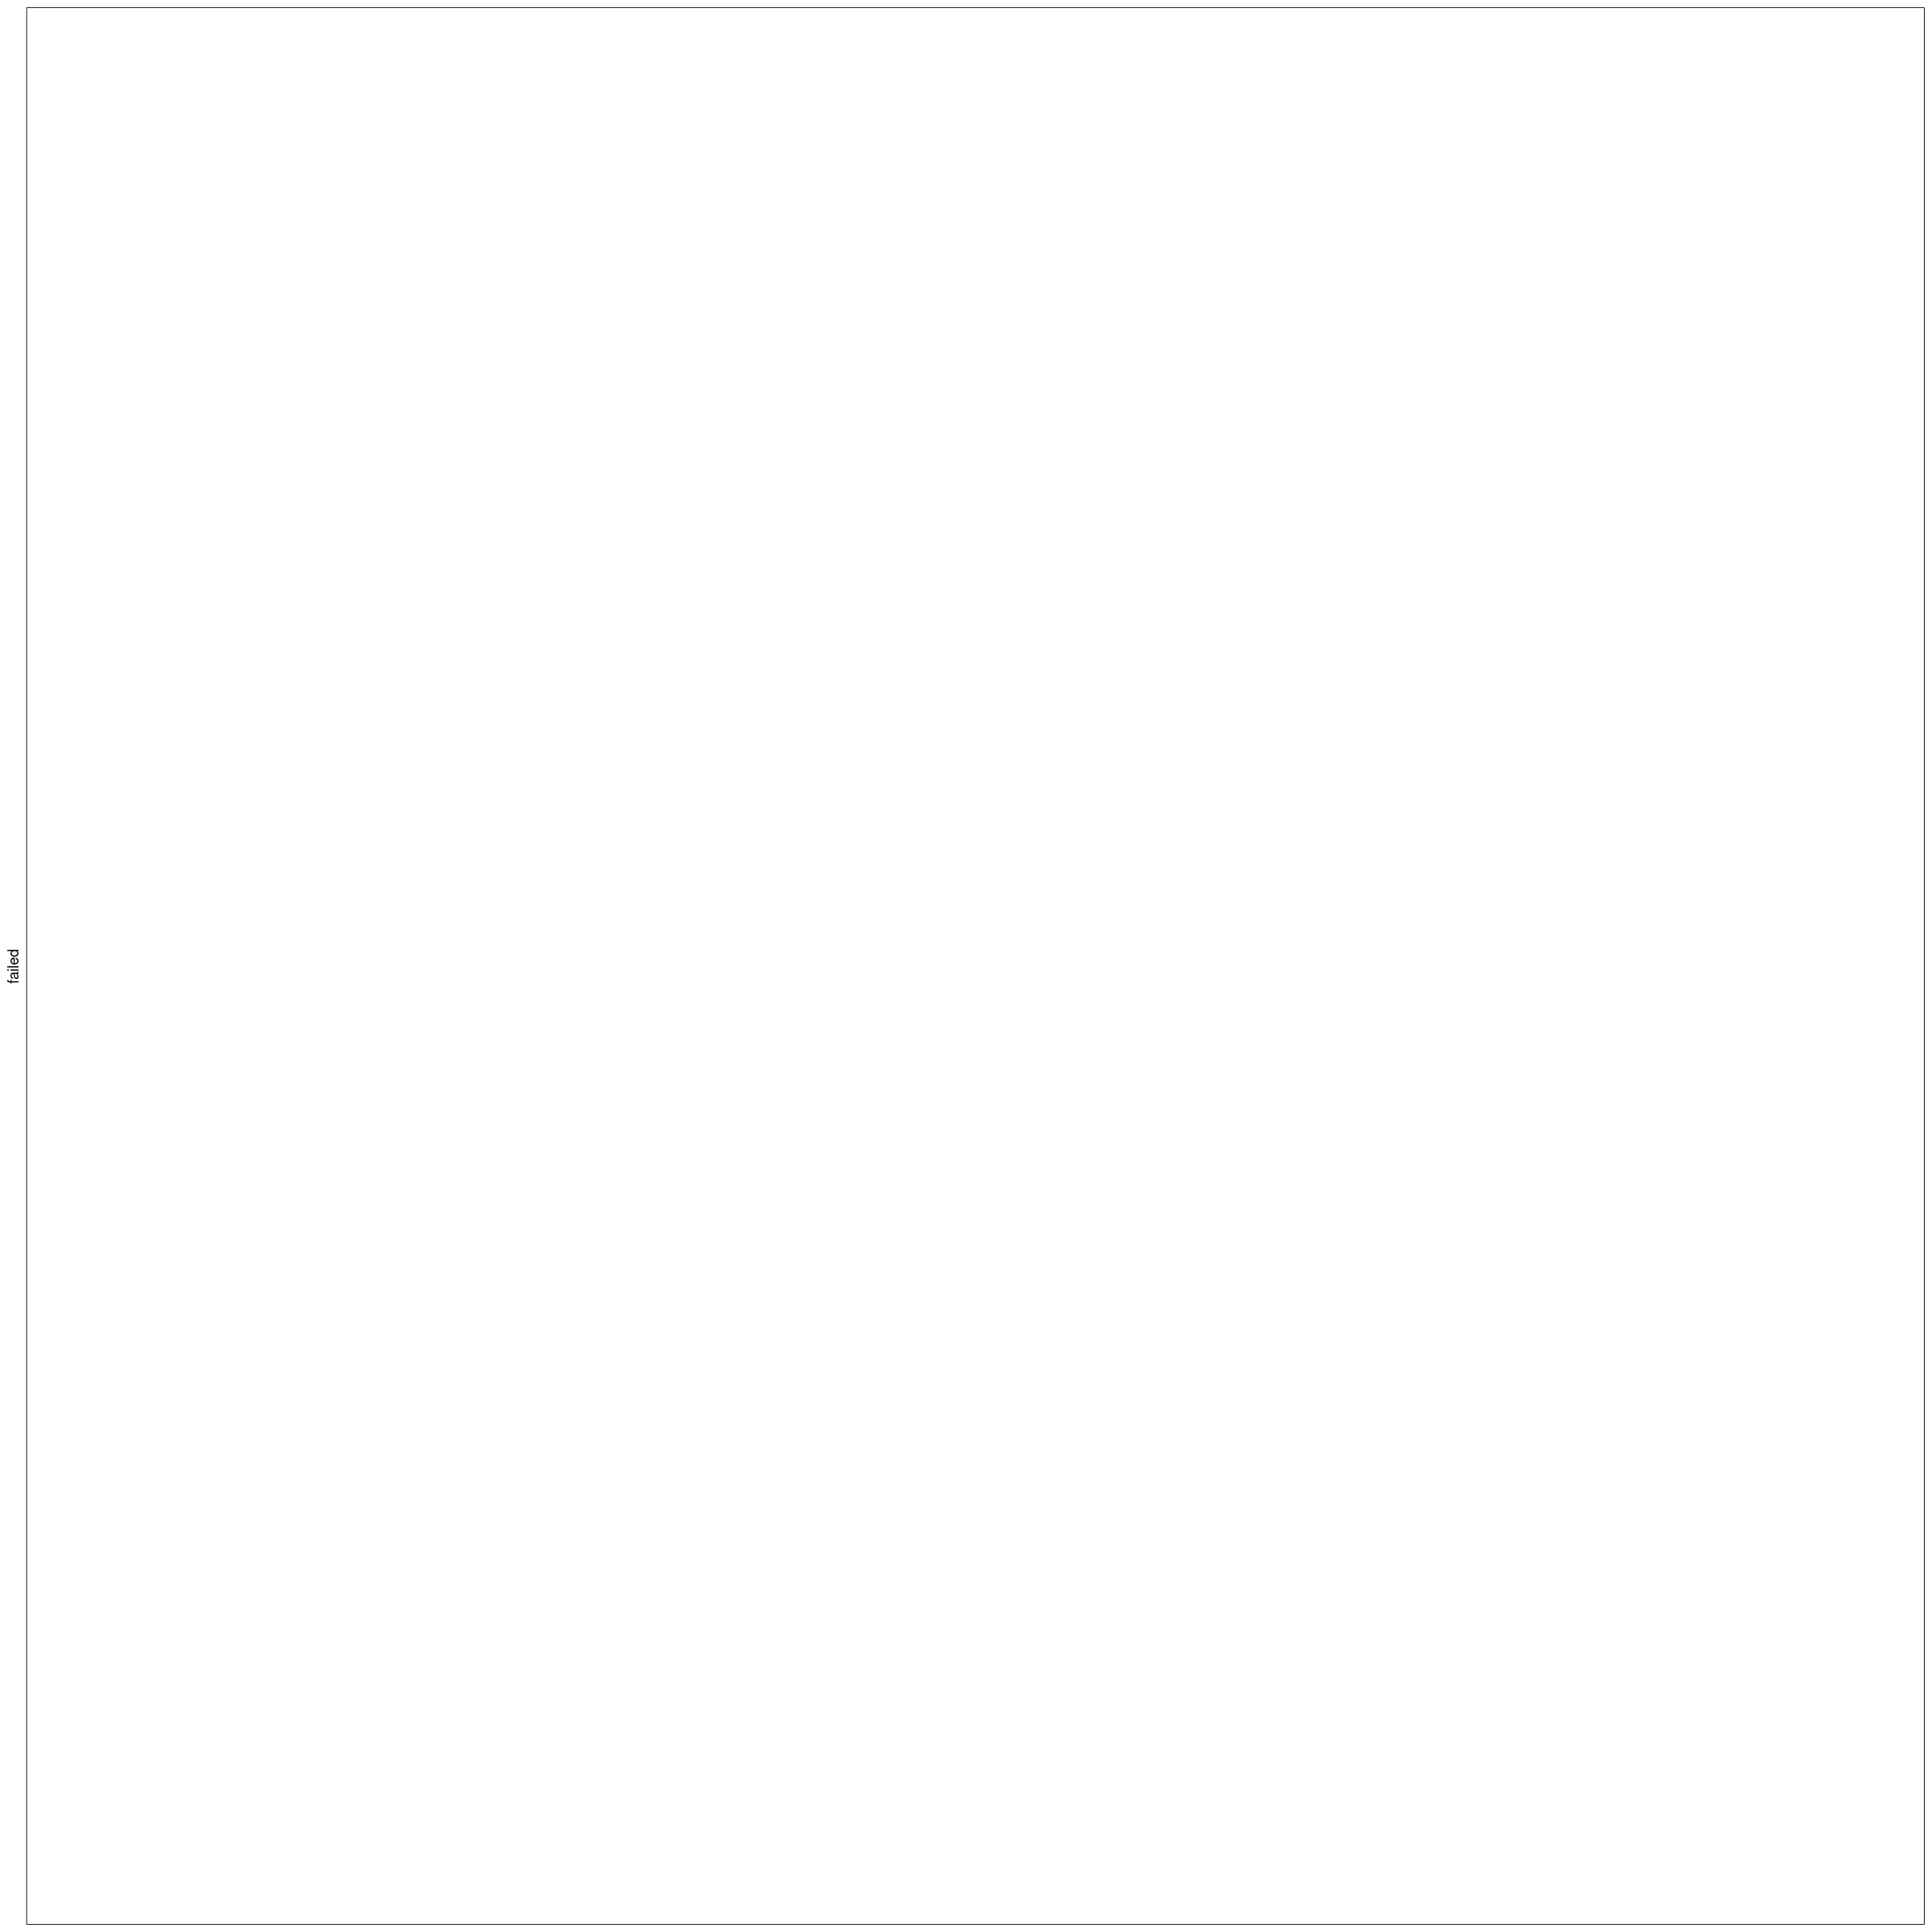

In [79]:
fails <- errors %>%
  group_by(folder, period) %>%
  summarise(failed = sum(value))

fails <- fails %>%
  # mutate(load = 1000 / period) %>%
  # inner_join(evol_sla_data, c("folder", "load")) %>%
  # mutate(dropped = failed / (above + respected + failed)) %>%
  {
    .
  }

fails

# fails <- evol_sla_data %>%
#     group_by(folder, target_offset) %>%
#     select(folder, target_offset) %>%
#     left_join(fails, by = c("folder")) %>%
#     {.}
# fails$dropped <- coalesce(fails$dropped, 0)


fails <- fails %>%
  ggplot(
    aes(
      x = folder,
      y = failed,
      # color = latency_type,
    )
  ) +
  # geom_line() +
  geom_point() +
  # geom_rug(sides="l") +
  # scale_y_reverse(label=scales::percent) +
  # scale_y_reverse()+
  # scale_x_discrete(position = "top") +
  # labs(
  #   x = "Load (req/s)",
  #   y = "Errors",
  #   # title = "Ratio of errors for send window vs load.",
  #   color = "Placment model"
  # ) +
  theme(
    axis.title.x = element_blank()
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)
fails
# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75))


`summarise()` has grouped output by 'timestamp', 'metric_group', 'target_offset', 'latency_type', 'load_type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



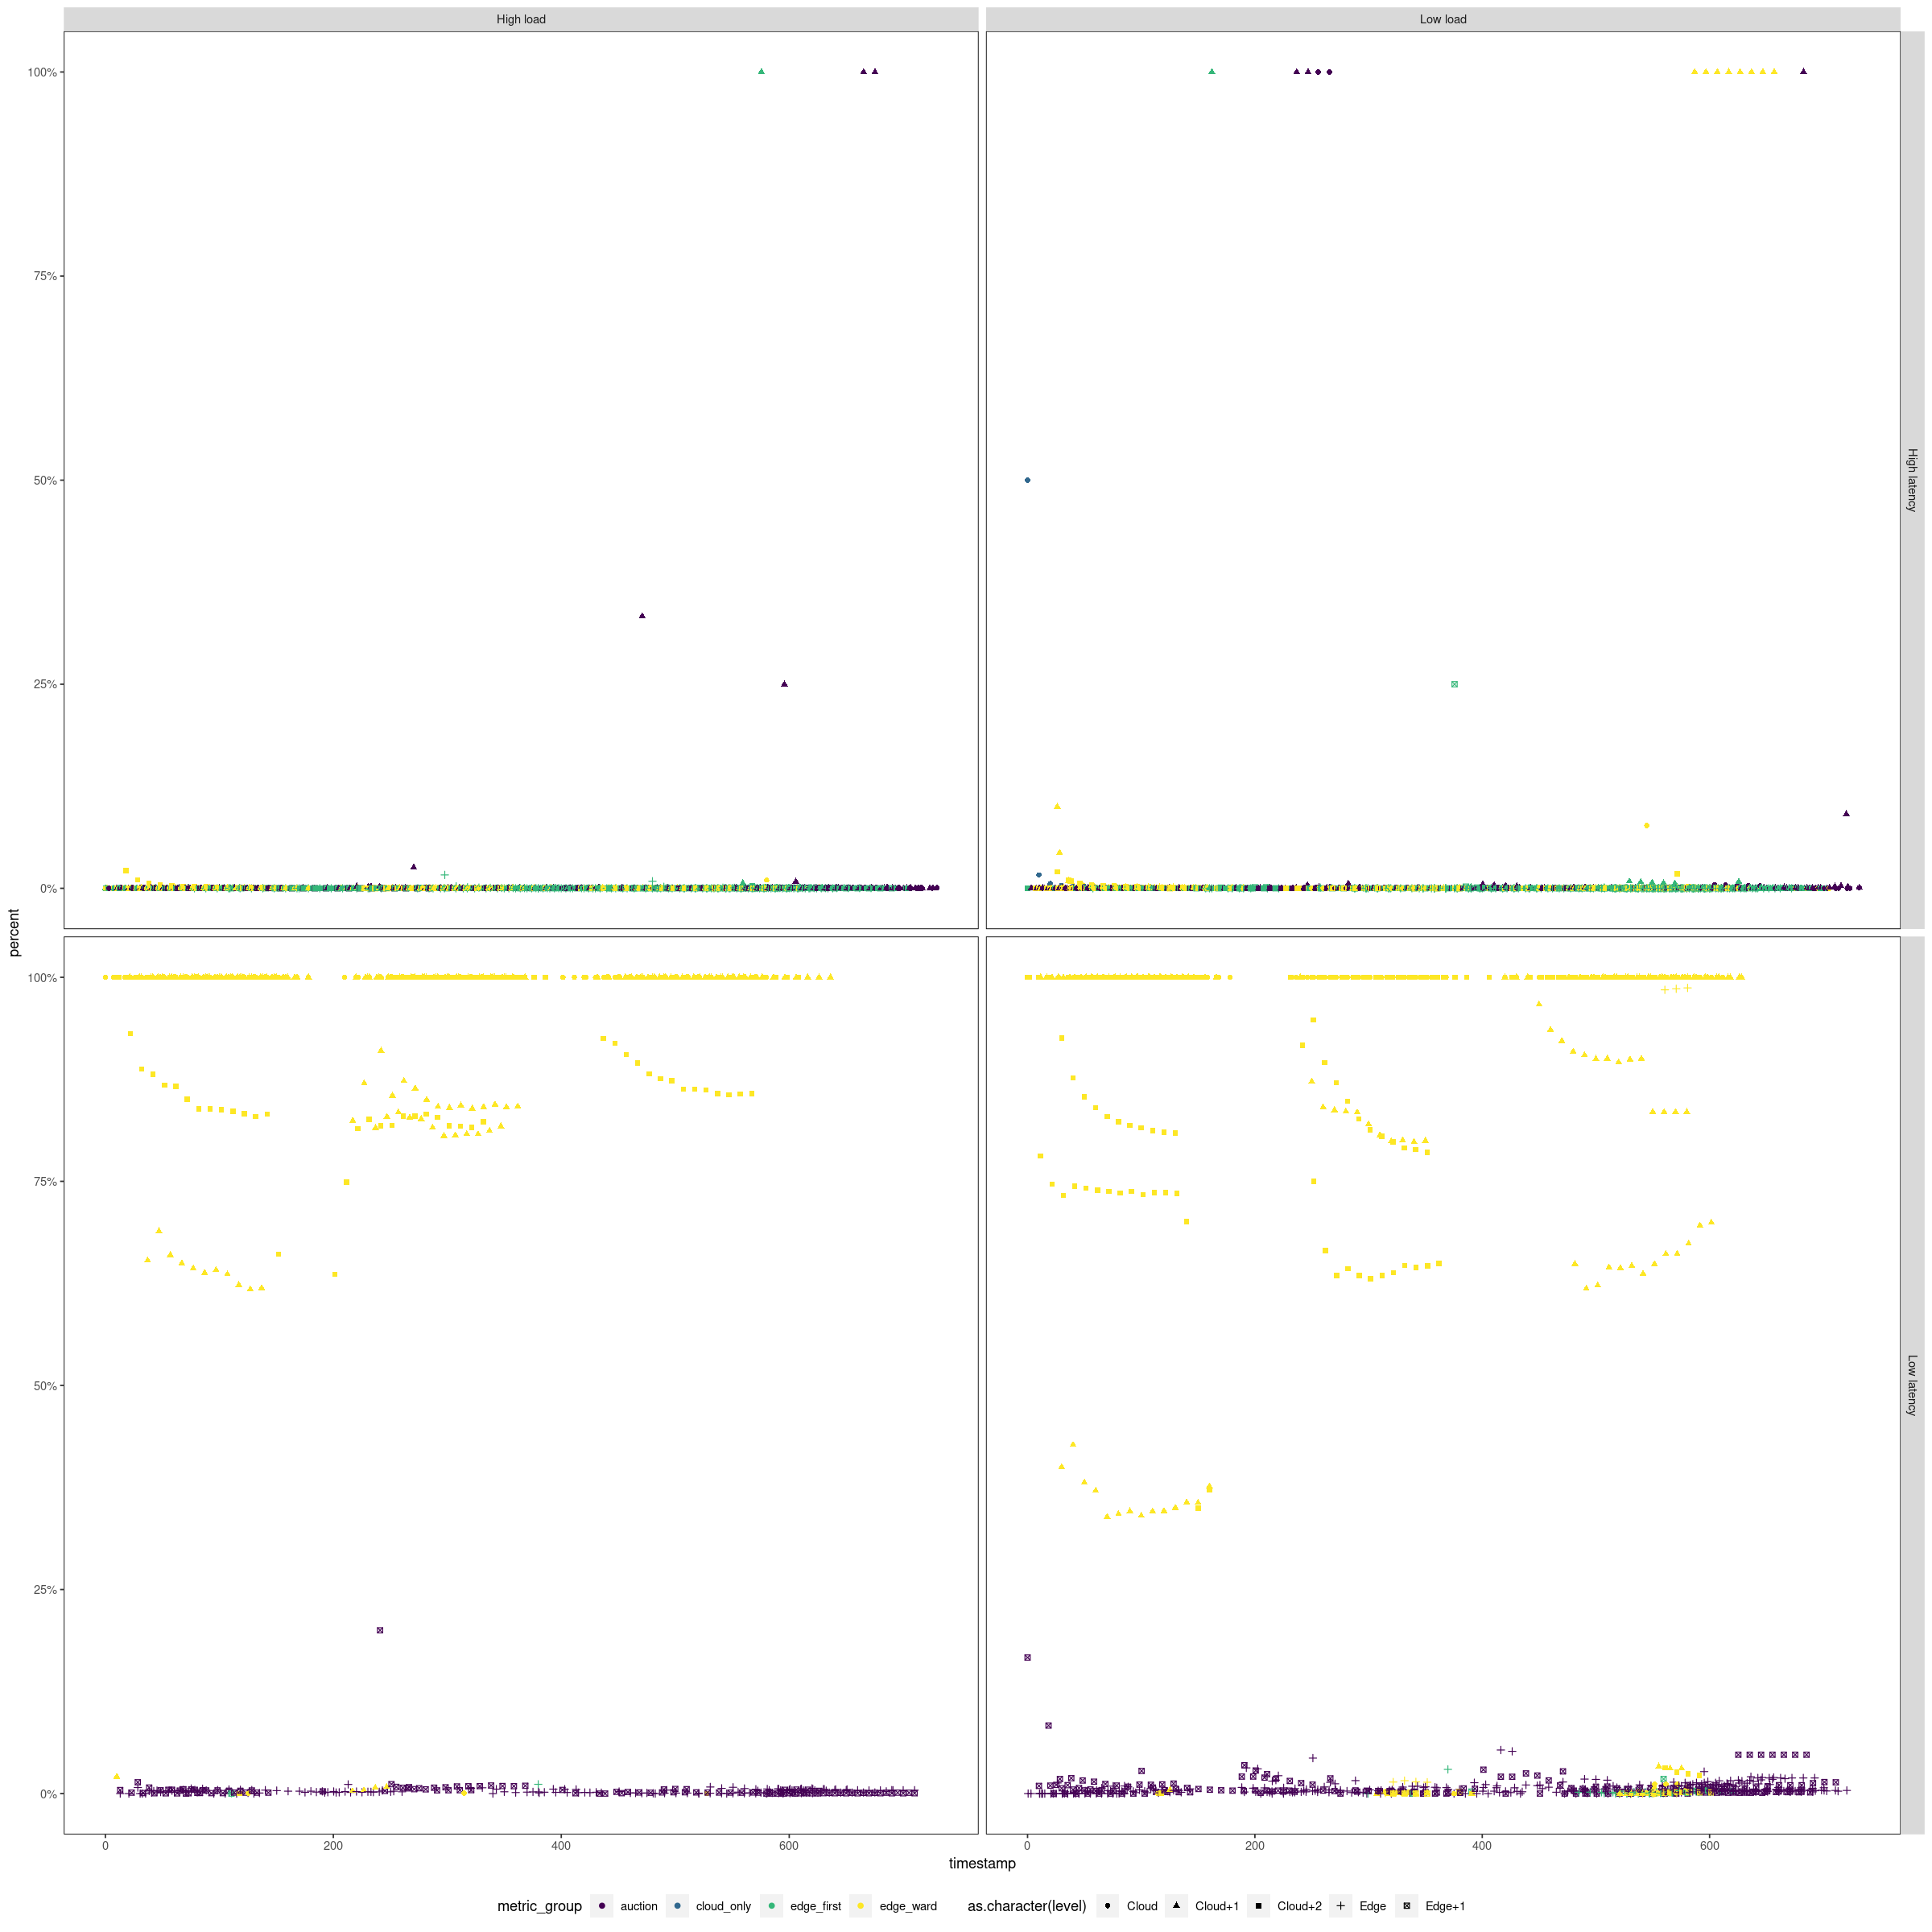

In [80]:
evol_sla_data <- sla_stats %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  group_by(timestamp, metric_group, target_offset, latency_type, load_type, level) %>%
  # mutate(timestamp = round(timestamp)) %>%
  summarize(above = sum(above), respected = sum(value_bucket)) %>%
  # mutate(respected = sum(value_bucket)) %>%
  mutate(percent = above / (above + respected)) %>%
  # spread(key = target_offset, value = percent) %>%
  {
    .
  }

evol_sla <- evol_sla_data %>%
  filter(target_offset == 0) %>%
  ggplot(
    aes(
      x = timestamp,
      y = percent,
      color = metric_group,
      # fill = load_type,
      shape = as.character(level),
    )
  ) +
  # geom_col(position="dodge") +
  geom_point() +
  # geom_line() +
  # geom_col(position="dodge") +
  # geom_rug(sides="l") +
  # geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.003))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.003))$percent), width=0.5) +
  # geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.002))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.002))$percent), width=1.5) +
  # geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.001))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.001))$percent), width=3) +
  scale_y_continuous(label = scales::percent) +
  # labs(
  #   x = "Load (req/s)",
  #   y = "SLA breaks over number of requests emitted",
  #   title = "Evolution of SLA breaks vs total load sent."
  # ) +
  facet_grid(rows = vars(latency_type), cols = vars(load_type), scales = "free") +
  # facet_grid(rows = vars(latency_type),cols=vars(load_type), scales="free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)
# theme(        axis.title.x = element_blank(),
#         legend.position = "none")
evol_sla


In [81]:
# average_with_rmse <- average_sum %>%
#     group_by(folder, load, latency) %>%
#     inner_join(sla_stats) %>%
#     mutate(percent = total / (respected + broken)) %>%
#     {.}

# average_with_rmse %>%
#     ggplot(
#       aes(
#         x = as.numeric(le),
#         y = percent,
#         color = factor(round(load)),
#       )
#     ) +
#     geom_line() +
#     # scale_fill_gradient(trans = 'pseudo_log') +
#     # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
#     scale_fill_viridis_c(option="inferno") +
#     # scale_fill_gradient2(low="white",high="red") +
#     scale_y_continuous(label = scales::percent) +
#     facet_grid(rows = vars(folder)) +
#     labs(
#       x = "Load (req/s)",
#       y = "SLA latency targets (ms)",
#       title = "RMSE of latencies",
#       subtitle = "Perceived by the node",
#       fill = "RMSE (s)"
#     )


In [82]:
deployment_times_raw <-
  load_csv("market_function_deployment_time.csv") %>%
  prepare() %>%
  extract_function_name_info()

# head(deployment_times_raw)


`summarise()` has grouped output by 'load_type', 'latency_type', 'bid_id', 'function_name'. You can override using the `.groups` argument.


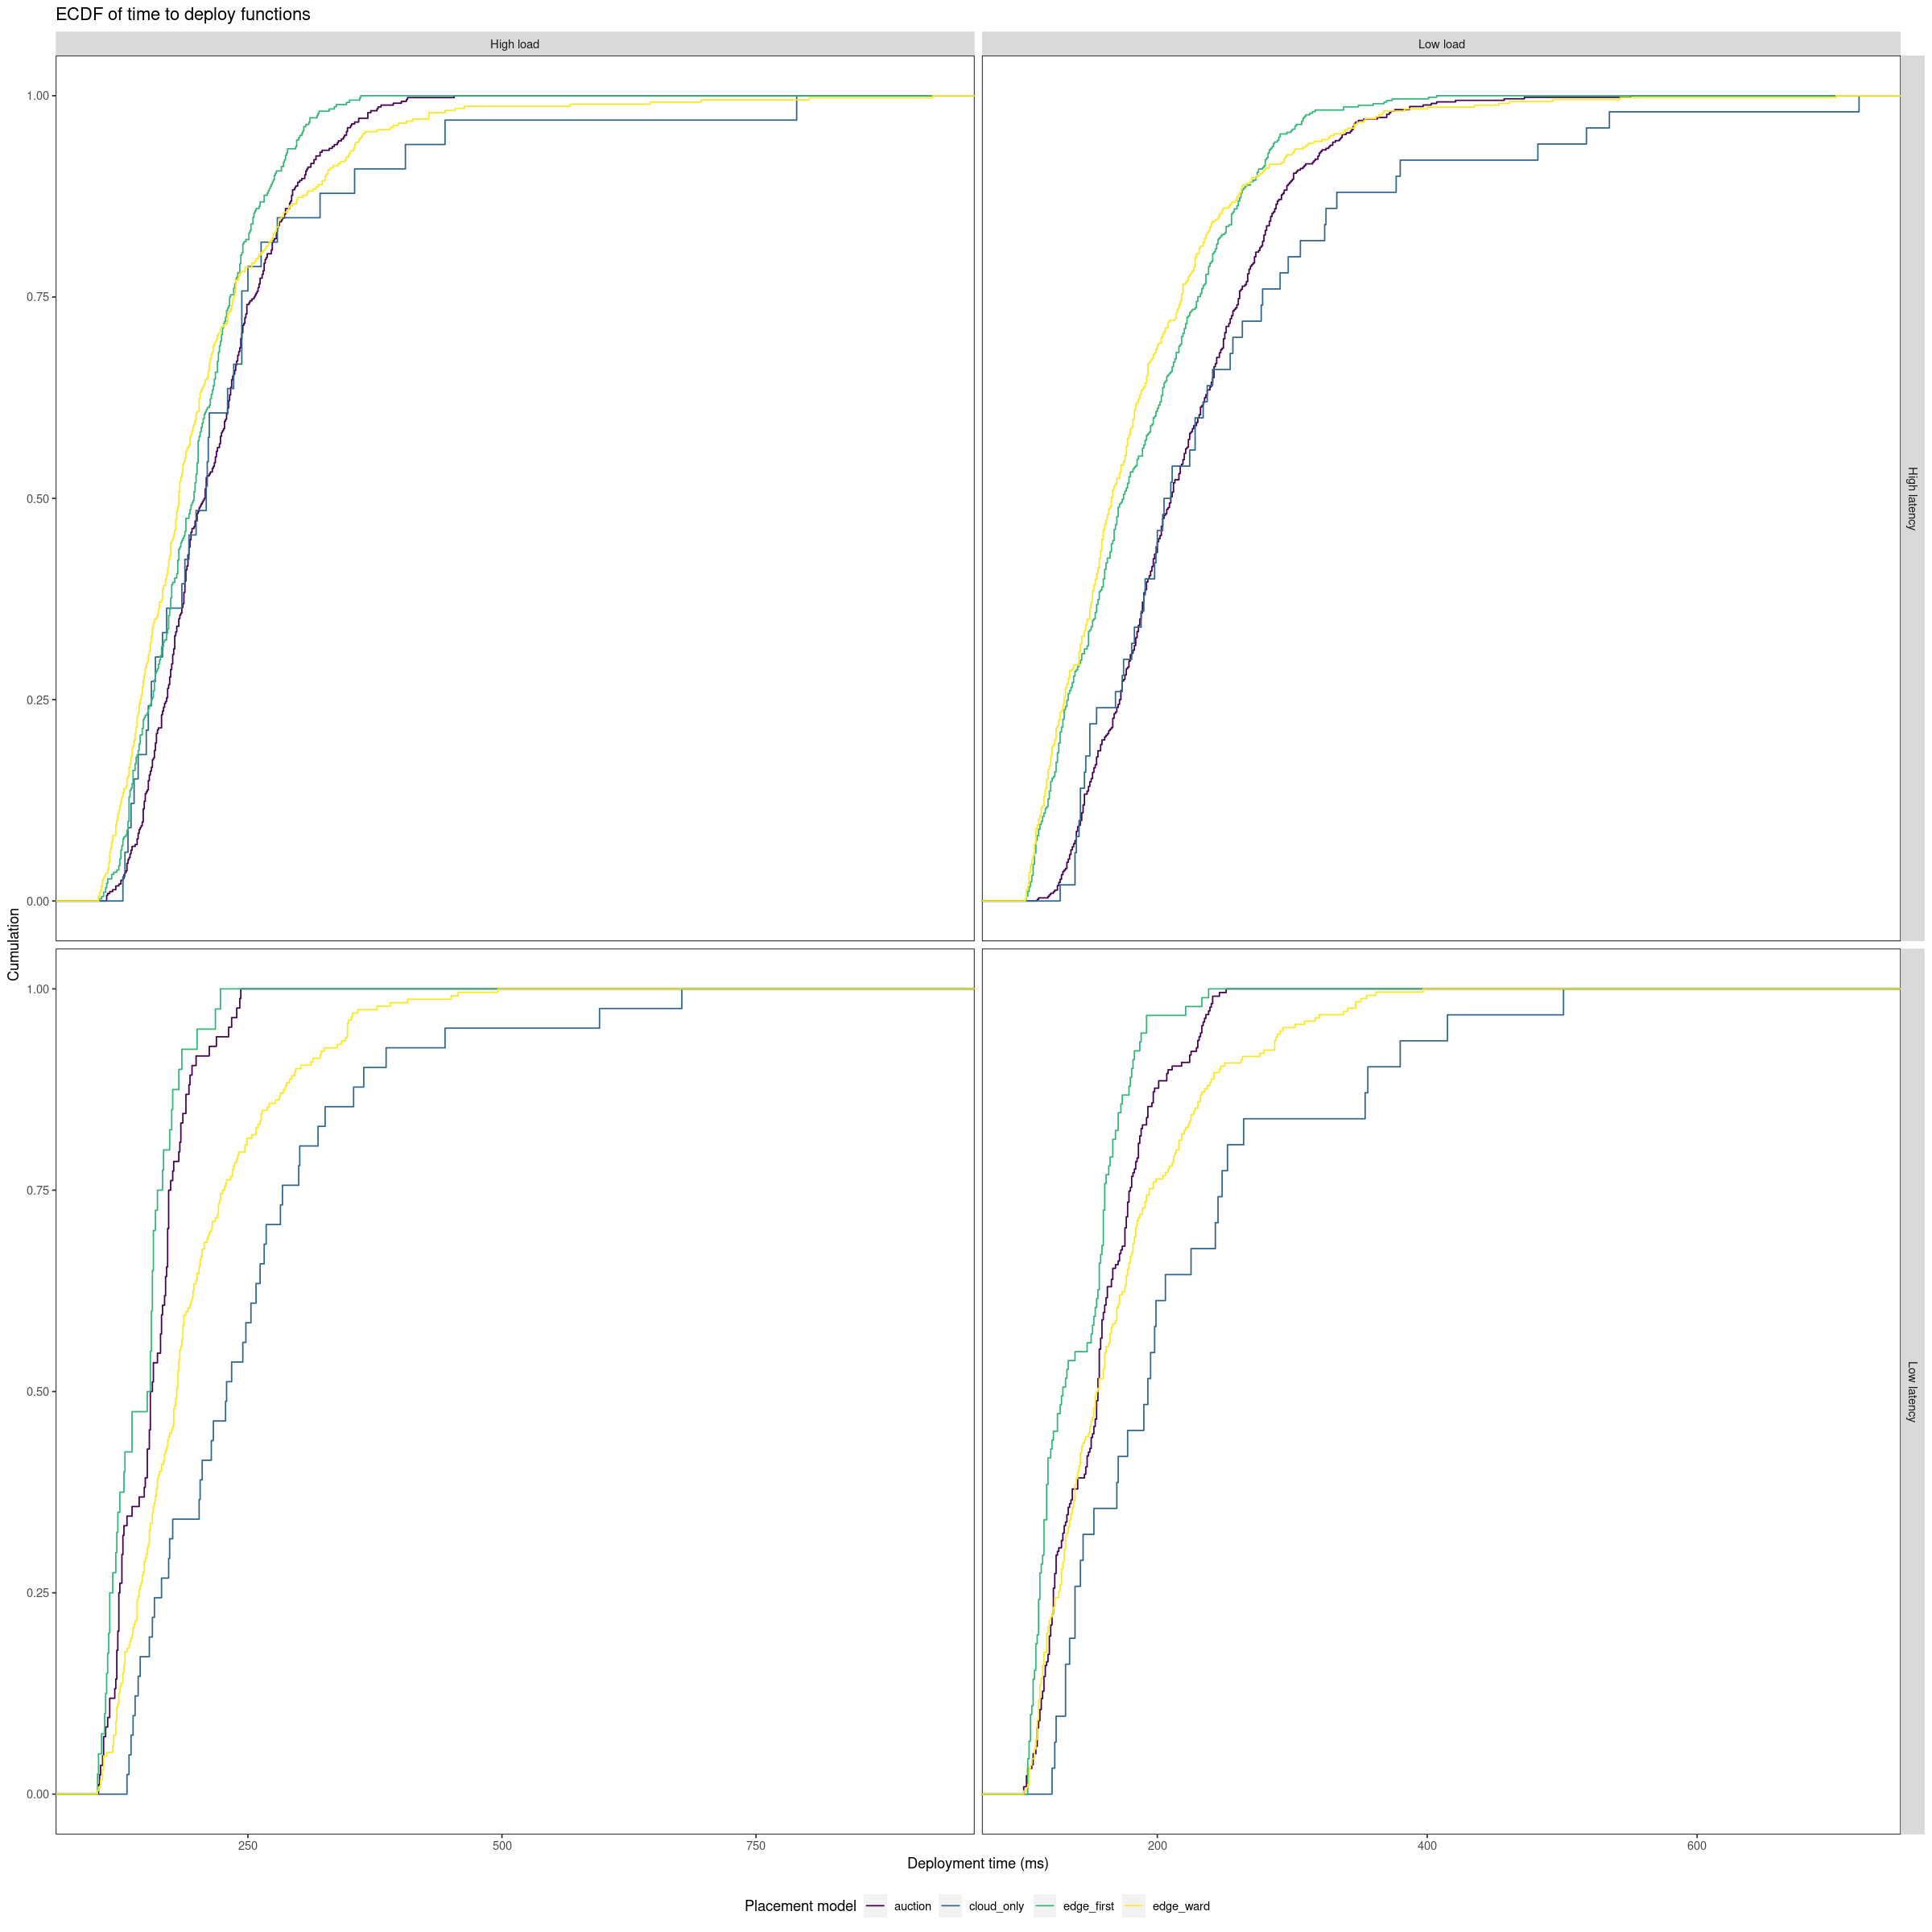

In [99]:
deployment_times <- deployment_times_raw %>%
  select(load_type, bid_id, latency_type, function_name, metric_group, value) %>%
  distinct() %>%
  drop_na() %>%
  group_by(load_type, latency_type, bid_id, function_name, metric_group) %>%
  summarize(min_time = min(value), avg_time = mean(value), max_time = max(value)) %>%
  {
    .
  }

# head(deployment_times)

deployment_times %>%
  ggplot(
    aes(
      x = avg_time * 1000,
      # y = value,
      color = metric_group,
    )
  ) +
  stat_ecdf() +
  # scale_x_continuous(trans = "log10") +
  # facet_grid(rows = varslatency_type) +
  facet_grid(rows = vars(latency_type), cols = vars(load_type), scales = "free") +
  labs(
    x = "Deployment time (ms)",
    y = "Cumulation",
    title = "ECDF of time to deploy functions",
    color = "Placement model"
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)
